In [1]:
#from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [2]:
#import zipfile

zip_path = '/kaggle/input/dataset'  # Adjust path if necessary
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


IsADirectoryError: [Errno 21] Is a directory: '/kaggle/input/dataset'

In [1]:
!pip install tensorflow numpy Pillow


In [3]:
# Import necessary libraries
import zipfile
import glob
from PIL import Image
import numpy as np
from tqdm import tqdm  # For progress bars



# Load and preprocess images
image_paths = sorted(glob.glob('/kaggle/input/dataset/plans/*.png'))
images = []

# Convert images to grayscale, resize, and normalize
for img_path in tqdm(image_paths, desc="Loading and processing images"):
    img = Image.open(img_path).convert('L').resize((64, 64))  # Convert to grayscale
    images.append(np.array(img))

# Convert list to numpy array and normalize to [-1, 1] range
images = np.array(images) / 127.5 - 1.0  # Scale to [-1, 1]

# Load text descriptions
text_paths = sorted(glob.glob('/kaggle/input/dataset/captions/*.txt'))

# Function to load text descriptions
def load_text_descriptions(text_paths):
    descriptions = []
    for path in text_paths:
        with open(path, 'r') as f:
            descriptions.append(f.read().strip())
    return descriptions


descriptions = load_text_descriptions(text_paths)

# Confirm loading
print(f"Loaded {len(images)} grayscale images and {len(descriptions)} descriptions.")

Loading and processing images: 100%|██████████| 1500/1500 [00:28<00:00, 53.15it/s]


Loaded 1500 grayscale images and 1500 descriptions.


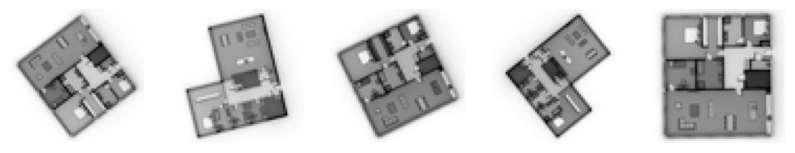

In [4]:
import matplotlib.pyplot as plt

# Display a few sample images
num_samples = 5  # Number of images to display
plt.figure(figsize=(10, 5))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(images[i], cmap='gray')  # Display in grayscale
    plt.axis('off')

plt.show()


In [6]:
# Import TensorFlow and necessary modules
import tensorflow as tf
from tensorflow.keras import layers
from transformers import BertTokenizer, TFBertModel

# Define the Generator model
def make_generator_model(z_dim, text_embedding_dim):
    model = tf.keras.Sequential([
        layers.Dense(256, input_dim=z_dim + text_embedding_dim),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1024),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(64 * 64, activation='tanh'),  # Output for grayscale images
        layers.Reshape((64, 64, 1))  # Grayscale channel
    ])
    return model

# Define the Discriminator model with label smoothing and dropout
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(64, 64, 1)),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Load BERT tokenizer and model for text embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Function to generate text embeddings
def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
    outputs = bert_model(**inputs)
    return tf.reduce_mean(outputs.last_hidden_state, axis=1)

# Set hyperparameters
z_dim = 100
text_embedding_dim = 768
epochs = 1000
batch_size = 16

# Learning rate scheduler for the discriminator
initial_lr = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)

# Define optimizers with learning rate scheduling
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [7]:
# Define training function for GAN with label smoothing and gradient clipping
def train_gan(generator, discriminator, epochs, batch_size, z_dim, images, descriptions):
    for epoch in range(epochs):
        epoch_gen_loss = 0
        epoch_disc_loss = 0

        for i in tqdm(range(len(images) // batch_size), desc=f"Epoch {epoch+1}/{epochs}"):
            # Generate random noise
            z = tf.random.normal([batch_size, z_dim])

            # Get text embeddings for the current batch
            text_embedding = get_text_embedding(descriptions[i * batch_size:(i + 1) * batch_size])

            # Train the Generator
            with tf.GradientTape() as gen_tape:
                generated_images = generator(tf.concat([z, text_embedding], axis=1), training=True)
                fake_output = discriminator(generated_images, training=True)
                gen_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            clipped_gradients_gen = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients_of_generator]
            generator_optimizer.apply_gradients(zip(clipped_gradients_gen, generator.trainable_variables))

            # Train the Discriminator
            real_images = images[i * batch_size:(i + 1) * batch_size]
            real_images = np.expand_dims(real_images, axis=-1)  # Ensure grayscale shape compatibility
            real_labels = tf.ones_like(fake_output) * 0.9  # Label smoothing
            fake_labels = tf.zeros_like(fake_output)

            with tf.GradientTape() as disc_tape:
                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(generated_images, training=True)
                disc_loss_real = tf.keras.losses.binary_crossentropy(real_labels, real_output)
                disc_loss_fake = tf.keras.losses.binary_crossentropy(fake_labels, fake_output)
                disc_loss = disc_loss_real + disc_loss_fake

            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            clipped_gradients_disc = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients_of_discriminator]
            discriminator_optimizer.apply_gradients(zip(clipped_gradients_disc, discriminator.trainable_variables))

            # Accumulate batch losses for the epoch
            epoch_gen_loss += gen_loss.numpy().mean()
            epoch_disc_loss += disc_loss.numpy().mean()

        # Calculate average loss for the epoch and print
        avg_gen_loss = epoch_gen_loss / (len(images) // batch_size)
        avg_disc_loss = epoch_disc_loss / (len(images) // batch_size)
        print(f"Epoch {epoch+1}/{epochs} - Generator loss: {avg_gen_loss:.4f}, Discriminator loss: {avg_disc_loss:.4f}")

# Instantiate generator and discriminator models
generator = make_generator_model(z_dim, text_embedding_dim)
discriminator = make_discriminator_model()

# Start training
train_gan(generator, discriminator, epochs, batch_size, z_dim, images, descriptions)



/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/1000: 100%|██████████| 93/93 [00:41<00:00,  2.23it/s]


Epoch 1/1000 - Generator loss: 0.9879, Discriminator loss: 1.0478


Epoch 2/1000: 100%|██████████| 93/93 [00:36<00:00,  2.55it/s]


Epoch 2/1000 - Generator loss: 1.9547, Discriminator loss: 0.5861


Epoch 3/1000: 100%|██████████| 93/93 [00:36<00:00,  2.56it/s]


Epoch 3/1000 - Generator loss: 2.1755, Discriminator loss: 0.6013


Epoch 4/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 4/1000 - Generator loss: 2.0523, Discriminator loss: 0.7185


Epoch 5/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 5/1000 - Generator loss: 1.6849, Discriminator loss: 0.9239


Epoch 6/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 6/1000 - Generator loss: 1.4177, Discriminator loss: 1.0671


Epoch 7/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 7/1000 - Generator loss: 1.3197, Discriminator loss: 1.0991


Epoch 8/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 8/1000 - Generator loss: 1.2895, Discriminator loss: 1.1323


Epoch 9/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 9/1000 - Generator loss: 1.2964, Discriminator loss: 1.1527


Epoch 10/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 10/1000 - Generator loss: 1.2737, Discriminator loss: 1.1691


Epoch 11/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 11/1000 - Generator loss: 1.2482, Discriminator loss: 1.1863


Epoch 12/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 12/1000 - Generator loss: 1.2072, Discriminator loss: 1.1525


Epoch 13/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 13/1000 - Generator loss: 1.1771, Discriminator loss: 1.1869


Epoch 14/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 14/1000 - Generator loss: 1.1360, Discriminator loss: 1.2151


Epoch 15/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 15/1000 - Generator loss: 1.1168, Discriminator loss: 1.2172


Epoch 16/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 16/1000 - Generator loss: 1.1430, Discriminator loss: 1.2023


Epoch 17/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 17/1000 - Generator loss: 1.1321, Discriminator loss: 1.2113


Epoch 18/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 18/1000 - Generator loss: 1.1339, Discriminator loss: 1.2049


Epoch 19/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 19/1000 - Generator loss: 1.0898, Discriminator loss: 1.2441


Epoch 20/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 20/1000 - Generator loss: 1.1690, Discriminator loss: 1.2515


Epoch 21/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 21/1000 - Generator loss: 1.1369, Discriminator loss: 1.2088


Epoch 22/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 22/1000 - Generator loss: 1.1278, Discriminator loss: 1.2063


Epoch 23/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 23/1000 - Generator loss: 1.1609, Discriminator loss: 1.1816


Epoch 24/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 24/1000 - Generator loss: 1.1416, Discriminator loss: 1.2011


Epoch 25/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 25/1000 - Generator loss: 1.1653, Discriminator loss: 1.2042


Epoch 26/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 26/1000 - Generator loss: 1.1249, Discriminator loss: 1.2312


Epoch 27/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 27/1000 - Generator loss: 1.0652, Discriminator loss: 1.2625


Epoch 28/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 28/1000 - Generator loss: 1.0790, Discriminator loss: 1.2512


Epoch 29/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 29/1000 - Generator loss: 1.1170, Discriminator loss: 1.2100


Epoch 30/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 30/1000 - Generator loss: 1.0819, Discriminator loss: 1.2606


Epoch 31/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 31/1000 - Generator loss: 1.1139, Discriminator loss: 1.2327


Epoch 32/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 32/1000 - Generator loss: 1.1256, Discriminator loss: 1.2380


Epoch 33/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 33/1000 - Generator loss: 1.0660, Discriminator loss: 1.2448


Epoch 34/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 34/1000 - Generator loss: 1.0888, Discriminator loss: 1.2086


Epoch 35/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 35/1000 - Generator loss: 1.1103, Discriminator loss: 1.2294


Epoch 36/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 36/1000 - Generator loss: 1.1044, Discriminator loss: 1.2652


Epoch 37/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 37/1000 - Generator loss: 1.0931, Discriminator loss: 1.2348


Epoch 38/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 38/1000 - Generator loss: 1.1262, Discriminator loss: 1.2568


Epoch 39/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 39/1000 - Generator loss: 1.0427, Discriminator loss: 1.2655


Epoch 40/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 40/1000 - Generator loss: 1.0747, Discriminator loss: 1.2566


Epoch 41/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 41/1000 - Generator loss: 1.0484, Discriminator loss: 1.2709


Epoch 42/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 42/1000 - Generator loss: 1.0723, Discriminator loss: 1.2971


Epoch 43/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 43/1000 - Generator loss: 1.0425, Discriminator loss: 1.2362


Epoch 44/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 44/1000 - Generator loss: 1.0438, Discriminator loss: 1.2675


Epoch 45/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 45/1000 - Generator loss: 1.0316, Discriminator loss: 1.2502


Epoch 46/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 46/1000 - Generator loss: 1.0416, Discriminator loss: 1.2633


Epoch 47/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 47/1000 - Generator loss: 1.0182, Discriminator loss: 1.2551


Epoch 48/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 48/1000 - Generator loss: 1.0560, Discriminator loss: 1.2590


Epoch 49/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 49/1000 - Generator loss: 1.0960, Discriminator loss: 1.2328


Epoch 50/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 50/1000 - Generator loss: 1.0878, Discriminator loss: 1.2669


Epoch 51/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 51/1000 - Generator loss: 1.0916, Discriminator loss: 1.2299


Epoch 52/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 52/1000 - Generator loss: 1.0792, Discriminator loss: 1.2536


Epoch 53/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 53/1000 - Generator loss: 1.0540, Discriminator loss: 1.2433


Epoch 54/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 54/1000 - Generator loss: 1.0343, Discriminator loss: 1.2691


Epoch 55/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 55/1000 - Generator loss: 1.0224, Discriminator loss: 1.2921


Epoch 56/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 56/1000 - Generator loss: 1.0439, Discriminator loss: 1.2561


Epoch 57/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 57/1000 - Generator loss: 1.0390, Discriminator loss: 1.2720


Epoch 58/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 58/1000 - Generator loss: 1.0487, Discriminator loss: 1.2678


Epoch 59/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 59/1000 - Generator loss: 1.0346, Discriminator loss: 1.2766


Epoch 60/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 60/1000 - Generator loss: 1.0384, Discriminator loss: 1.2539


Epoch 61/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 61/1000 - Generator loss: 1.0190, Discriminator loss: 1.2861


Epoch 62/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 62/1000 - Generator loss: 0.9719, Discriminator loss: 1.3250


Epoch 63/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 63/1000 - Generator loss: 0.9585, Discriminator loss: 1.3133


Epoch 64/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 64/1000 - Generator loss: 0.9961, Discriminator loss: 1.3093


Epoch 65/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 65/1000 - Generator loss: 0.9955, Discriminator loss: 1.2884


Epoch 66/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 66/1000 - Generator loss: 0.9922, Discriminator loss: 1.3048


Epoch 67/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 67/1000 - Generator loss: 1.0061, Discriminator loss: 1.2590


Epoch 68/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 68/1000 - Generator loss: 1.0015, Discriminator loss: 1.3043


Epoch 69/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 69/1000 - Generator loss: 0.9887, Discriminator loss: 1.2871


Epoch 70/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 70/1000 - Generator loss: 0.9992, Discriminator loss: 1.3047


Epoch 71/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 71/1000 - Generator loss: 1.0160, Discriminator loss: 1.2902


Epoch 72/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 72/1000 - Generator loss: 1.0238, Discriminator loss: 1.2375


Epoch 73/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 73/1000 - Generator loss: 1.0787, Discriminator loss: 1.2489


Epoch 74/1000: 100%|██████████| 93/93 [00:36<00:00,  2.56it/s]


Epoch 74/1000 - Generator loss: 1.0372, Discriminator loss: 1.2597


Epoch 75/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 75/1000 - Generator loss: 1.0245, Discriminator loss: 1.2769


Epoch 76/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 76/1000 - Generator loss: 0.9645, Discriminator loss: 1.3297


Epoch 77/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 77/1000 - Generator loss: 0.9667, Discriminator loss: 1.3300


Epoch 78/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 78/1000 - Generator loss: 0.9832, Discriminator loss: 1.2749


Epoch 79/1000: 100%|██████████| 93/93 [00:36<00:00,  2.57it/s]


Epoch 79/1000 - Generator loss: 0.9941, Discriminator loss: 1.2681


Epoch 80/1000: 100%|██████████| 93/93 [00:36<00:00,  2.57it/s]


Epoch 80/1000 - Generator loss: 1.0384, Discriminator loss: 1.2663


Epoch 81/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 81/1000 - Generator loss: 1.0255, Discriminator loss: 1.2574


Epoch 82/1000: 100%|██████████| 93/93 [00:36<00:00,  2.57it/s]


Epoch 82/1000 - Generator loss: 1.0155, Discriminator loss: 1.2508


Epoch 83/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 83/1000 - Generator loss: 1.0494, Discriminator loss: 1.2608


Epoch 84/1000: 100%|██████████| 93/93 [00:36<00:00,  2.56it/s]


Epoch 84/1000 - Generator loss: 1.0380, Discriminator loss: 1.2495


Epoch 85/1000: 100%|██████████| 93/93 [00:35<00:00,  2.58it/s]


Epoch 85/1000 - Generator loss: 1.0441, Discriminator loss: 1.2742


Epoch 86/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 86/1000 - Generator loss: 1.0008, Discriminator loss: 1.3037


Epoch 87/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 87/1000 - Generator loss: 0.9923, Discriminator loss: 1.2770


Epoch 88/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 88/1000 - Generator loss: 0.9682, Discriminator loss: 1.3174


Epoch 89/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 89/1000 - Generator loss: 0.9782, Discriminator loss: 1.3011


Epoch 90/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 90/1000 - Generator loss: 0.9825, Discriminator loss: 1.2987


Epoch 91/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 91/1000 - Generator loss: 0.9869, Discriminator loss: 1.2984


Epoch 92/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 92/1000 - Generator loss: 0.9767, Discriminator loss: 1.3060


Epoch 93/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 93/1000 - Generator loss: 0.9417, Discriminator loss: 1.3231


Epoch 94/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 94/1000 - Generator loss: 0.9800, Discriminator loss: 1.3048


Epoch 95/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 95/1000 - Generator loss: 0.9976, Discriminator loss: 1.3060


Epoch 96/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 96/1000 - Generator loss: 0.9831, Discriminator loss: 1.3310


Epoch 97/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 97/1000 - Generator loss: 0.9876, Discriminator loss: 1.3010


Epoch 98/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 98/1000 - Generator loss: 0.9808, Discriminator loss: 1.2968


Epoch 99/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 99/1000 - Generator loss: 0.9669, Discriminator loss: 1.2900


Epoch 100/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 100/1000 - Generator loss: 0.9842, Discriminator loss: 1.2785


Epoch 101/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 101/1000 - Generator loss: 0.9500, Discriminator loss: 1.3017


Epoch 102/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 102/1000 - Generator loss: 0.9442, Discriminator loss: 1.3032


Epoch 103/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 103/1000 - Generator loss: 0.9639, Discriminator loss: 1.3132


Epoch 104/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 104/1000 - Generator loss: 0.9449, Discriminator loss: 1.3175


Epoch 105/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 105/1000 - Generator loss: 0.9843, Discriminator loss: 1.3002


Epoch 106/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 106/1000 - Generator loss: 0.9594, Discriminator loss: 1.3073


Epoch 107/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 107/1000 - Generator loss: 0.9518, Discriminator loss: 1.3197


Epoch 108/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 108/1000 - Generator loss: 0.9601, Discriminator loss: 1.2957


Epoch 109/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 109/1000 - Generator loss: 0.9393, Discriminator loss: 1.3575


Epoch 110/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 110/1000 - Generator loss: 0.9453, Discriminator loss: 1.3393


Epoch 111/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 111/1000 - Generator loss: 0.9375, Discriminator loss: 1.2889


Epoch 112/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 112/1000 - Generator loss: 0.9443, Discriminator loss: 1.3021


Epoch 113/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 113/1000 - Generator loss: 0.9532, Discriminator loss: 1.2975


Epoch 114/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 114/1000 - Generator loss: 0.9635, Discriminator loss: 1.2914


Epoch 115/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 115/1000 - Generator loss: 0.9730, Discriminator loss: 1.2680


Epoch 116/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 116/1000 - Generator loss: 0.9906, Discriminator loss: 1.2596


Epoch 117/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 117/1000 - Generator loss: 0.9939, Discriminator loss: 1.2999


Epoch 118/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 118/1000 - Generator loss: 0.9639, Discriminator loss: 1.2996


Epoch 119/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 119/1000 - Generator loss: 0.9174, Discriminator loss: 1.3335


Epoch 120/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 120/1000 - Generator loss: 0.9439, Discriminator loss: 1.3334


Epoch 121/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 121/1000 - Generator loss: 0.9346, Discriminator loss: 1.3143


Epoch 122/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 122/1000 - Generator loss: 0.9465, Discriminator loss: 1.3189


Epoch 123/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 123/1000 - Generator loss: 0.9487, Discriminator loss: 1.3053


Epoch 124/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 124/1000 - Generator loss: 0.9704, Discriminator loss: 1.2921


Epoch 125/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 125/1000 - Generator loss: 0.9672, Discriminator loss: 1.3070


Epoch 126/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 126/1000 - Generator loss: 0.9469, Discriminator loss: 1.3358


Epoch 127/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 127/1000 - Generator loss: 0.9200, Discriminator loss: 1.3229


Epoch 128/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 128/1000 - Generator loss: 0.9304, Discriminator loss: 1.3333


Epoch 129/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 129/1000 - Generator loss: 0.9411, Discriminator loss: 1.3259


Epoch 130/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 130/1000 - Generator loss: 0.9204, Discriminator loss: 1.3246


Epoch 131/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 131/1000 - Generator loss: 0.9240, Discriminator loss: 1.3268


Epoch 132/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 132/1000 - Generator loss: 0.9196, Discriminator loss: 1.3262


Epoch 133/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 133/1000 - Generator loss: 0.9062, Discriminator loss: 1.3420


Epoch 134/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 134/1000 - Generator loss: 0.9145, Discriminator loss: 1.3420


Epoch 135/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 135/1000 - Generator loss: 0.8856, Discriminator loss: 1.3642


Epoch 136/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 136/1000 - Generator loss: 0.8991, Discriminator loss: 1.3436


Epoch 137/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 137/1000 - Generator loss: 0.8778, Discriminator loss: 1.3579


Epoch 138/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 138/1000 - Generator loss: 0.8980, Discriminator loss: 1.3407


Epoch 139/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 139/1000 - Generator loss: 0.9058, Discriminator loss: 1.3145


Epoch 140/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 140/1000 - Generator loss: 0.9289, Discriminator loss: 1.3386


Epoch 141/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 141/1000 - Generator loss: 0.9040, Discriminator loss: 1.3458


Epoch 142/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 142/1000 - Generator loss: 0.8822, Discriminator loss: 1.3362


Epoch 143/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 143/1000 - Generator loss: 0.8943, Discriminator loss: 1.3431


Epoch 144/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 144/1000 - Generator loss: 0.9001, Discriminator loss: 1.3477


Epoch 145/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 145/1000 - Generator loss: 0.8997, Discriminator loss: 1.3392


Epoch 146/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 146/1000 - Generator loss: 0.9125, Discriminator loss: 1.3179


Epoch 147/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 147/1000 - Generator loss: 0.9089, Discriminator loss: 1.3260


Epoch 148/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 148/1000 - Generator loss: 0.9239, Discriminator loss: 1.3328


Epoch 149/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 149/1000 - Generator loss: 0.9109, Discriminator loss: 1.3038


Epoch 150/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 150/1000 - Generator loss: 0.9072, Discriminator loss: 1.3339


Epoch 151/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 151/1000 - Generator loss: 0.8945, Discriminator loss: 1.3529


Epoch 152/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 152/1000 - Generator loss: 0.8757, Discriminator loss: 1.3833


Epoch 153/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 153/1000 - Generator loss: 0.8539, Discriminator loss: 1.3860


Epoch 154/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 154/1000 - Generator loss: 0.8627, Discriminator loss: 1.3819


Epoch 155/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 155/1000 - Generator loss: 0.8670, Discriminator loss: 1.3720


Epoch 156/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 156/1000 - Generator loss: 0.8545, Discriminator loss: 1.3865


Epoch 157/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 157/1000 - Generator loss: 0.8530, Discriminator loss: 1.3865


Epoch 158/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 158/1000 - Generator loss: 0.8522, Discriminator loss: 1.3865


Epoch 159/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 159/1000 - Generator loss: 0.8366, Discriminator loss: 1.3850


Epoch 160/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 160/1000 - Generator loss: 0.8554, Discriminator loss: 1.4029


Epoch 161/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 161/1000 - Generator loss: 0.8566, Discriminator loss: 1.3839


Epoch 162/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 162/1000 - Generator loss: 0.8278, Discriminator loss: 1.3947


Epoch 163/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 163/1000 - Generator loss: 0.8206, Discriminator loss: 1.4125


Epoch 164/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 164/1000 - Generator loss: 0.8480, Discriminator loss: 1.3887


Epoch 165/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 165/1000 - Generator loss: 0.8413, Discriminator loss: 1.3868


Epoch 166/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 166/1000 - Generator loss: 0.8441, Discriminator loss: 1.3663


Epoch 167/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 167/1000 - Generator loss: 0.8559, Discriminator loss: 1.3714


Epoch 168/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 168/1000 - Generator loss: 0.8409, Discriminator loss: 1.3900


Epoch 169/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 169/1000 - Generator loss: 0.8631, Discriminator loss: 1.3918


Epoch 170/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 170/1000 - Generator loss: 0.8404, Discriminator loss: 1.3969


Epoch 171/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 171/1000 - Generator loss: 0.8482, Discriminator loss: 1.3654


Epoch 172/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 172/1000 - Generator loss: 0.8499, Discriminator loss: 1.3792


Epoch 173/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 173/1000 - Generator loss: 0.8224, Discriminator loss: 1.3997


Epoch 174/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 174/1000 - Generator loss: 0.8302, Discriminator loss: 1.3813


Epoch 175/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 175/1000 - Generator loss: 0.8421, Discriminator loss: 1.3928


Epoch 176/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 176/1000 - Generator loss: 0.8398, Discriminator loss: 1.3827


Epoch 177/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 177/1000 - Generator loss: 0.8402, Discriminator loss: 1.3698


Epoch 178/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 178/1000 - Generator loss: 0.8112, Discriminator loss: 1.3959


Epoch 179/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 179/1000 - Generator loss: 0.8389, Discriminator loss: 1.3839


Epoch 180/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 180/1000 - Generator loss: 0.8355, Discriminator loss: 1.3823


Epoch 181/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 181/1000 - Generator loss: 0.8277, Discriminator loss: 1.3837


Epoch 182/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 182/1000 - Generator loss: 0.8388, Discriminator loss: 1.3873


Epoch 183/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 183/1000 - Generator loss: 0.8623, Discriminator loss: 1.3822


Epoch 184/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 184/1000 - Generator loss: 0.8148, Discriminator loss: 1.3928


Epoch 185/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 185/1000 - Generator loss: 0.8137, Discriminator loss: 1.3968


Epoch 186/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 186/1000 - Generator loss: 0.8260, Discriminator loss: 1.3918


Epoch 187/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 187/1000 - Generator loss: 0.8094, Discriminator loss: 1.3972


Epoch 188/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 188/1000 - Generator loss: 0.8287, Discriminator loss: 1.3879


Epoch 189/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 189/1000 - Generator loss: 0.8282, Discriminator loss: 1.3948


Epoch 190/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 190/1000 - Generator loss: 0.8418, Discriminator loss: 1.3872


Epoch 191/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 191/1000 - Generator loss: 0.8079, Discriminator loss: 1.4059


Epoch 192/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 192/1000 - Generator loss: 0.8204, Discriminator loss: 1.4080


Epoch 193/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 193/1000 - Generator loss: 0.8090, Discriminator loss: 1.4056


Epoch 194/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 194/1000 - Generator loss: 0.8053, Discriminator loss: 1.4000


Epoch 195/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 195/1000 - Generator loss: 0.7984, Discriminator loss: 1.4090


Epoch 196/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 196/1000 - Generator loss: 0.7994, Discriminator loss: 1.4060


Epoch 197/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 197/1000 - Generator loss: 0.8186, Discriminator loss: 1.4009


Epoch 198/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 198/1000 - Generator loss: 0.7970, Discriminator loss: 1.4083


Epoch 199/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 199/1000 - Generator loss: 0.8027, Discriminator loss: 1.4033


Epoch 200/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 200/1000 - Generator loss: 0.7867, Discriminator loss: 1.4075


Epoch 201/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 201/1000 - Generator loss: 0.8013, Discriminator loss: 1.4117


Epoch 202/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 202/1000 - Generator loss: 0.8138, Discriminator loss: 1.3963


Epoch 203/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 203/1000 - Generator loss: 0.8117, Discriminator loss: 1.3986


Epoch 204/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 204/1000 - Generator loss: 0.8202, Discriminator loss: 1.3904


Epoch 205/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 205/1000 - Generator loss: 0.8018, Discriminator loss: 1.4091


Epoch 206/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 206/1000 - Generator loss: 0.7988, Discriminator loss: 1.4036


Epoch 207/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 207/1000 - Generator loss: 0.8100, Discriminator loss: 1.3959


Epoch 208/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 208/1000 - Generator loss: 0.7982, Discriminator loss: 1.3936


Epoch 209/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 209/1000 - Generator loss: 0.8034, Discriminator loss: 1.4008


Epoch 210/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 210/1000 - Generator loss: 0.8005, Discriminator loss: 1.4068


Epoch 211/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 211/1000 - Generator loss: 0.7944, Discriminator loss: 1.3984


Epoch 212/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 212/1000 - Generator loss: 0.8130, Discriminator loss: 1.3925


Epoch 213/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 213/1000 - Generator loss: 0.8157, Discriminator loss: 1.3845


Epoch 214/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 214/1000 - Generator loss: 0.7947, Discriminator loss: 1.4061


Epoch 215/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 215/1000 - Generator loss: 0.8170, Discriminator loss: 1.3845


Epoch 216/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 216/1000 - Generator loss: 0.8032, Discriminator loss: 1.4018


Epoch 217/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 217/1000 - Generator loss: 0.8181, Discriminator loss: 1.3869


Epoch 218/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 218/1000 - Generator loss: 0.8245, Discriminator loss: 1.3856


Epoch 219/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 219/1000 - Generator loss: 0.8287, Discriminator loss: 1.3901


Epoch 220/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 220/1000 - Generator loss: 0.8231, Discriminator loss: 1.3935


Epoch 221/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 221/1000 - Generator loss: 0.8348, Discriminator loss: 1.3892


Epoch 222/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 222/1000 - Generator loss: 0.8294, Discriminator loss: 1.3738


Epoch 223/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 223/1000 - Generator loss: 0.8225, Discriminator loss: 1.3864


Epoch 224/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 224/1000 - Generator loss: 0.8152, Discriminator loss: 1.3949


Epoch 225/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 225/1000 - Generator loss: 0.8227, Discriminator loss: 1.3892


Epoch 226/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 226/1000 - Generator loss: 0.8268, Discriminator loss: 1.3733


Epoch 227/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 227/1000 - Generator loss: 0.8144, Discriminator loss: 1.3854


Epoch 228/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 228/1000 - Generator loss: 0.7968, Discriminator loss: 1.4103


Epoch 229/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 229/1000 - Generator loss: 0.8221, Discriminator loss: 1.3803


Epoch 230/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 230/1000 - Generator loss: 0.8027, Discriminator loss: 1.3988


Epoch 231/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 231/1000 - Generator loss: 0.8044, Discriminator loss: 1.4043


Epoch 232/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 232/1000 - Generator loss: 0.7986, Discriminator loss: 1.3957


Epoch 233/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 233/1000 - Generator loss: 0.7904, Discriminator loss: 1.4097


Epoch 234/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 234/1000 - Generator loss: 0.7904, Discriminator loss: 1.3958


Epoch 235/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 235/1000 - Generator loss: 0.7995, Discriminator loss: 1.3978


Epoch 236/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 236/1000 - Generator loss: 0.8009, Discriminator loss: 1.3929


Epoch 237/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 237/1000 - Generator loss: 0.7948, Discriminator loss: 1.3987


Epoch 238/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 238/1000 - Generator loss: 0.7961, Discriminator loss: 1.3889


Epoch 239/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 239/1000 - Generator loss: 0.7916, Discriminator loss: 1.3967


Epoch 240/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 240/1000 - Generator loss: 0.8004, Discriminator loss: 1.3919


Epoch 241/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 241/1000 - Generator loss: 0.8033, Discriminator loss: 1.3812


Epoch 242/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 242/1000 - Generator loss: 0.7907, Discriminator loss: 1.3883


Epoch 243/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 243/1000 - Generator loss: 0.7965, Discriminator loss: 1.3929


Epoch 244/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 244/1000 - Generator loss: 0.8142, Discriminator loss: 1.3859


Epoch 245/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 245/1000 - Generator loss: 0.8009, Discriminator loss: 1.3924


Epoch 246/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 246/1000 - Generator loss: 0.8028, Discriminator loss: 1.3859


Epoch 247/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 247/1000 - Generator loss: 0.7984, Discriminator loss: 1.3876


Epoch 248/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 248/1000 - Generator loss: 0.8021, Discriminator loss: 1.3906


Epoch 249/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 249/1000 - Generator loss: 0.8042, Discriminator loss: 1.3870


Epoch 250/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 250/1000 - Generator loss: 0.8095, Discriminator loss: 1.3823


Epoch 251/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 251/1000 - Generator loss: 0.8157, Discriminator loss: 1.3862


Epoch 252/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 252/1000 - Generator loss: 0.8123, Discriminator loss: 1.3831


Epoch 253/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 253/1000 - Generator loss: 0.8191, Discriminator loss: 1.3906


Epoch 254/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 254/1000 - Generator loss: 0.8214, Discriminator loss: 1.3778


Epoch 255/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 255/1000 - Generator loss: 0.8295, Discriminator loss: 1.3792


Epoch 256/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 256/1000 - Generator loss: 0.8060, Discriminator loss: 1.3889


Epoch 257/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 257/1000 - Generator loss: 0.8190, Discriminator loss: 1.3952


Epoch 258/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 258/1000 - Generator loss: 0.8350, Discriminator loss: 1.3694


Epoch 259/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 259/1000 - Generator loss: 0.8086, Discriminator loss: 1.3817


Epoch 260/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 260/1000 - Generator loss: 0.8007, Discriminator loss: 1.3904


Epoch 261/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 261/1000 - Generator loss: 0.8192, Discriminator loss: 1.3863


Epoch 262/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 262/1000 - Generator loss: 0.8115, Discriminator loss: 1.3978


Epoch 263/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 263/1000 - Generator loss: 0.8125, Discriminator loss: 1.3961


Epoch 264/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 264/1000 - Generator loss: 0.8164, Discriminator loss: 1.3854


Epoch 265/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 265/1000 - Generator loss: 0.8173, Discriminator loss: 1.3879


Epoch 266/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 266/1000 - Generator loss: 0.8114, Discriminator loss: 1.3818


Epoch 267/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 267/1000 - Generator loss: 0.7812, Discriminator loss: 1.4101


Epoch 268/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 268/1000 - Generator loss: 0.8079, Discriminator loss: 1.3954


Epoch 269/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 269/1000 - Generator loss: 0.8201, Discriminator loss: 1.3976


Epoch 270/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 270/1000 - Generator loss: 0.7998, Discriminator loss: 1.4036


Epoch 271/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 271/1000 - Generator loss: 0.8022, Discriminator loss: 1.3838


Epoch 272/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 272/1000 - Generator loss: 0.7853, Discriminator loss: 1.4062


Epoch 273/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 273/1000 - Generator loss: 0.7875, Discriminator loss: 1.3951


Epoch 274/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 274/1000 - Generator loss: 0.8021, Discriminator loss: 1.3890


Epoch 275/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 275/1000 - Generator loss: 0.7929, Discriminator loss: 1.3903


Epoch 276/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 276/1000 - Generator loss: 0.7820, Discriminator loss: 1.3998


Epoch 277/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 277/1000 - Generator loss: 0.7873, Discriminator loss: 1.3994


Epoch 278/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 278/1000 - Generator loss: 0.8121, Discriminator loss: 1.3815


Epoch 279/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 279/1000 - Generator loss: 0.7995, Discriminator loss: 1.3867


Epoch 280/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 280/1000 - Generator loss: 0.8085, Discriminator loss: 1.3835


Epoch 281/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 281/1000 - Generator loss: 0.8196, Discriminator loss: 1.3769


Epoch 282/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 282/1000 - Generator loss: 0.8247, Discriminator loss: 1.3730


Epoch 283/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 283/1000 - Generator loss: 0.8275, Discriminator loss: 1.3754


Epoch 284/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 284/1000 - Generator loss: 0.8228, Discriminator loss: 1.3816


Epoch 285/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 285/1000 - Generator loss: 0.8324, Discriminator loss: 1.3753


Epoch 286/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 286/1000 - Generator loss: 0.8287, Discriminator loss: 1.3781


Epoch 287/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 287/1000 - Generator loss: 0.8148, Discriminator loss: 1.3813


Epoch 288/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 288/1000 - Generator loss: 0.8114, Discriminator loss: 1.3811


Epoch 289/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 289/1000 - Generator loss: 0.8059, Discriminator loss: 1.3870


Epoch 290/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 290/1000 - Generator loss: 0.7952, Discriminator loss: 1.3819


Epoch 291/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 291/1000 - Generator loss: 0.7937, Discriminator loss: 1.3817


Epoch 292/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 292/1000 - Generator loss: 0.7868, Discriminator loss: 1.3864


Epoch 293/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 293/1000 - Generator loss: 0.7831, Discriminator loss: 1.3881


Epoch 294/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 294/1000 - Generator loss: 0.7857, Discriminator loss: 1.3844


Epoch 295/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 295/1000 - Generator loss: 0.7766, Discriminator loss: 1.3842


Epoch 296/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 296/1000 - Generator loss: 0.7816, Discriminator loss: 1.3869


Epoch 297/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 297/1000 - Generator loss: 0.7779, Discriminator loss: 1.3867


Epoch 298/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 298/1000 - Generator loss: 0.7759, Discriminator loss: 1.3878


Epoch 299/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 299/1000 - Generator loss: 0.7772, Discriminator loss: 1.3863


Epoch 300/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 300/1000 - Generator loss: 0.7804, Discriminator loss: 1.3845


Epoch 301/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 301/1000 - Generator loss: 0.7804, Discriminator loss: 1.3835


Epoch 302/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 302/1000 - Generator loss: 0.7795, Discriminator loss: 1.3863


Epoch 303/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 303/1000 - Generator loss: 0.7787, Discriminator loss: 1.3879


Epoch 304/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 304/1000 - Generator loss: 0.7782, Discriminator loss: 1.3859


Epoch 305/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 305/1000 - Generator loss: 0.7778, Discriminator loss: 1.3785


Epoch 306/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 306/1000 - Generator loss: 0.7828, Discriminator loss: 1.3858


Epoch 307/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 307/1000 - Generator loss: 0.7751, Discriminator loss: 1.3850


Epoch 308/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 308/1000 - Generator loss: 0.7868, Discriminator loss: 1.3864


Epoch 309/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 309/1000 - Generator loss: 0.7931, Discriminator loss: 1.3876


Epoch 310/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 310/1000 - Generator loss: 0.7962, Discriminator loss: 1.3807


Epoch 311/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 311/1000 - Generator loss: 0.7973, Discriminator loss: 1.3870


Epoch 312/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 312/1000 - Generator loss: 0.7988, Discriminator loss: 1.3836


Epoch 313/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 313/1000 - Generator loss: 0.7997, Discriminator loss: 1.3912


Epoch 314/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 314/1000 - Generator loss: 0.7956, Discriminator loss: 1.3847


Epoch 315/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 315/1000 - Generator loss: 0.8009, Discriminator loss: 1.3829


Epoch 316/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 316/1000 - Generator loss: 0.7946, Discriminator loss: 1.3864


Epoch 317/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 317/1000 - Generator loss: 0.8041, Discriminator loss: 1.3816


Epoch 318/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 318/1000 - Generator loss: 0.7947, Discriminator loss: 1.3835


Epoch 319/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 319/1000 - Generator loss: 0.8056, Discriminator loss: 1.3822


Epoch 320/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 320/1000 - Generator loss: 0.8034, Discriminator loss: 1.3835


Epoch 321/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 321/1000 - Generator loss: 0.7992, Discriminator loss: 1.3868


Epoch 322/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 322/1000 - Generator loss: 0.8064, Discriminator loss: 1.3878


Epoch 323/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 323/1000 - Generator loss: 0.8024, Discriminator loss: 1.3869


Epoch 324/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 324/1000 - Generator loss: 0.8114, Discriminator loss: 1.3858


Epoch 325/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 325/1000 - Generator loss: 0.8077, Discriminator loss: 1.3875


Epoch 326/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 326/1000 - Generator loss: 0.8062, Discriminator loss: 1.3868


Epoch 327/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 327/1000 - Generator loss: 0.8045, Discriminator loss: 1.3815


Epoch 328/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 328/1000 - Generator loss: 0.7997, Discriminator loss: 1.3872


Epoch 329/1000: 100%|██████████| 93/93 [00:34<00:00,  2.70it/s]


Epoch 329/1000 - Generator loss: 0.8046, Discriminator loss: 1.3872


Epoch 330/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 330/1000 - Generator loss: 0.8029, Discriminator loss: 1.3877


Epoch 331/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 331/1000 - Generator loss: 0.7960, Discriminator loss: 1.3856


Epoch 332/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 332/1000 - Generator loss: 0.8075, Discriminator loss: 1.3857


Epoch 333/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 333/1000 - Generator loss: 0.7898, Discriminator loss: 1.3866


Epoch 334/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 334/1000 - Generator loss: 0.7940, Discriminator loss: 1.3886


Epoch 335/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 335/1000 - Generator loss: 0.7867, Discriminator loss: 1.3874


Epoch 336/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 336/1000 - Generator loss: 0.7968, Discriminator loss: 1.3880


Epoch 337/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 337/1000 - Generator loss: 0.7831, Discriminator loss: 1.3872


Epoch 338/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 338/1000 - Generator loss: 0.7910, Discriminator loss: 1.3883


Epoch 339/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 339/1000 - Generator loss: 0.7917, Discriminator loss: 1.3861


Epoch 340/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 340/1000 - Generator loss: 0.7880, Discriminator loss: 1.3847


Epoch 341/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 341/1000 - Generator loss: 0.7864, Discriminator loss: 1.3870


Epoch 342/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 342/1000 - Generator loss: 0.7948, Discriminator loss: 1.3838


Epoch 343/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 343/1000 - Generator loss: 0.7883, Discriminator loss: 1.3845


Epoch 344/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 344/1000 - Generator loss: 0.7905, Discriminator loss: 1.3871


Epoch 345/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 345/1000 - Generator loss: 0.7936, Discriminator loss: 1.3870


Epoch 346/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 346/1000 - Generator loss: 0.7919, Discriminator loss: 1.3851


Epoch 347/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 347/1000 - Generator loss: 0.7979, Discriminator loss: 1.3858


Epoch 348/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 348/1000 - Generator loss: 0.7939, Discriminator loss: 1.3853


Epoch 349/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 349/1000 - Generator loss: 0.7957, Discriminator loss: 1.3872


Epoch 350/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 350/1000 - Generator loss: 0.8026, Discriminator loss: 1.3833


Epoch 351/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 351/1000 - Generator loss: 0.7960, Discriminator loss: 1.3889


Epoch 352/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 352/1000 - Generator loss: 0.7978, Discriminator loss: 1.3846


Epoch 353/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 353/1000 - Generator loss: 0.7918, Discriminator loss: 1.3845


Epoch 354/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 354/1000 - Generator loss: 0.7862, Discriminator loss: 1.3854


Epoch 355/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 355/1000 - Generator loss: 0.7979, Discriminator loss: 1.3852


Epoch 356/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 356/1000 - Generator loss: 0.7923, Discriminator loss: 1.3870


Epoch 357/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 357/1000 - Generator loss: 0.7972, Discriminator loss: 1.3866


Epoch 358/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 358/1000 - Generator loss: 0.7855, Discriminator loss: 1.3835


Epoch 359/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 359/1000 - Generator loss: 0.7972, Discriminator loss: 1.3847


Epoch 360/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 360/1000 - Generator loss: 0.7946, Discriminator loss: 1.3865


Epoch 361/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 361/1000 - Generator loss: 0.8040, Discriminator loss: 1.3858


Epoch 362/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 362/1000 - Generator loss: 0.7926, Discriminator loss: 1.3844


Epoch 363/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 363/1000 - Generator loss: 0.7945, Discriminator loss: 1.3790


Epoch 364/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 364/1000 - Generator loss: 0.7987, Discriminator loss: 1.3876


Epoch 365/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 365/1000 - Generator loss: 0.8032, Discriminator loss: 1.3837


Epoch 366/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 366/1000 - Generator loss: 0.7992, Discriminator loss: 1.3872


Epoch 367/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 367/1000 - Generator loss: 0.7915, Discriminator loss: 1.3895


Epoch 368/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 368/1000 - Generator loss: 0.7909, Discriminator loss: 1.3840


Epoch 369/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 369/1000 - Generator loss: 0.7989, Discriminator loss: 1.3877


Epoch 370/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 370/1000 - Generator loss: 0.7910, Discriminator loss: 1.3821


Epoch 371/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 371/1000 - Generator loss: 0.7969, Discriminator loss: 1.3880


Epoch 372/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 372/1000 - Generator loss: 0.7885, Discriminator loss: 1.3836


Epoch 373/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 373/1000 - Generator loss: 0.7898, Discriminator loss: 1.3840


Epoch 374/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 374/1000 - Generator loss: 0.7877, Discriminator loss: 1.3831


Epoch 375/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 375/1000 - Generator loss: 0.7912, Discriminator loss: 1.3874


Epoch 376/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 376/1000 - Generator loss: 0.7908, Discriminator loss: 1.3828


Epoch 377/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 377/1000 - Generator loss: 0.7922, Discriminator loss: 1.3812


Epoch 378/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 378/1000 - Generator loss: 0.7955, Discriminator loss: 1.3858


Epoch 379/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 379/1000 - Generator loss: 0.7938, Discriminator loss: 1.3892


Epoch 380/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 380/1000 - Generator loss: 0.7977, Discriminator loss: 1.3835


Epoch 381/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 381/1000 - Generator loss: 0.8005, Discriminator loss: 1.3825


Epoch 382/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 382/1000 - Generator loss: 0.7977, Discriminator loss: 1.3823


Epoch 383/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 383/1000 - Generator loss: 0.7908, Discriminator loss: 1.3836


Epoch 384/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 384/1000 - Generator loss: 0.7988, Discriminator loss: 1.3821


Epoch 385/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 385/1000 - Generator loss: 0.7945, Discriminator loss: 1.3851


Epoch 386/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 386/1000 - Generator loss: 0.7899, Discriminator loss: 1.3873


Epoch 387/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 387/1000 - Generator loss: 0.7889, Discriminator loss: 1.3894


Epoch 388/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 388/1000 - Generator loss: 0.7929, Discriminator loss: 1.3860


Epoch 389/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 389/1000 - Generator loss: 0.7952, Discriminator loss: 1.3841


Epoch 390/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 390/1000 - Generator loss: 0.7956, Discriminator loss: 1.3833


Epoch 391/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 391/1000 - Generator loss: 0.7927, Discriminator loss: 1.3821


Epoch 392/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 392/1000 - Generator loss: 0.7976, Discriminator loss: 1.3879


Epoch 393/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 393/1000 - Generator loss: 0.8007, Discriminator loss: 1.3833


Epoch 394/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 394/1000 - Generator loss: 0.7949, Discriminator loss: 1.3819


Epoch 395/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 395/1000 - Generator loss: 0.7923, Discriminator loss: 1.3817


Epoch 396/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 396/1000 - Generator loss: 0.7980, Discriminator loss: 1.3844


Epoch 397/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 397/1000 - Generator loss: 0.7990, Discriminator loss: 1.3836


Epoch 398/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 398/1000 - Generator loss: 0.8009, Discriminator loss: 1.3812


Epoch 399/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 399/1000 - Generator loss: 0.7945, Discriminator loss: 1.3854


Epoch 400/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 400/1000 - Generator loss: 0.7952, Discriminator loss: 1.3827


Epoch 401/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 401/1000 - Generator loss: 0.7973, Discriminator loss: 1.3854


Epoch 402/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 402/1000 - Generator loss: 0.7965, Discriminator loss: 1.3845


Epoch 403/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 403/1000 - Generator loss: 0.7992, Discriminator loss: 1.3815


Epoch 404/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 404/1000 - Generator loss: 0.7930, Discriminator loss: 1.3844


Epoch 405/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 405/1000 - Generator loss: 0.7938, Discriminator loss: 1.3783


Epoch 406/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 406/1000 - Generator loss: 0.7987, Discriminator loss: 1.3832


Epoch 407/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 407/1000 - Generator loss: 0.7939, Discriminator loss: 1.3848


Epoch 408/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 408/1000 - Generator loss: 0.7943, Discriminator loss: 1.3818


Epoch 409/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 409/1000 - Generator loss: 0.7898, Discriminator loss: 1.3826


Epoch 410/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 410/1000 - Generator loss: 0.7928, Discriminator loss: 1.3819


Epoch 411/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 411/1000 - Generator loss: 0.7902, Discriminator loss: 1.3825


Epoch 412/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 412/1000 - Generator loss: 0.7952, Discriminator loss: 1.3835


Epoch 413/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 413/1000 - Generator loss: 0.7963, Discriminator loss: 1.3827


Epoch 414/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 414/1000 - Generator loss: 0.7916, Discriminator loss: 1.3829


Epoch 415/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 415/1000 - Generator loss: 0.7947, Discriminator loss: 1.3863


Epoch 416/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 416/1000 - Generator loss: 0.7931, Discriminator loss: 1.3851


Epoch 417/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 417/1000 - Generator loss: 0.7952, Discriminator loss: 1.3834


Epoch 418/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 418/1000 - Generator loss: 0.7923, Discriminator loss: 1.3811


Epoch 419/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 419/1000 - Generator loss: 0.7910, Discriminator loss: 1.3822


Epoch 420/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 420/1000 - Generator loss: 0.7947, Discriminator loss: 1.3802


Epoch 421/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 421/1000 - Generator loss: 0.7989, Discriminator loss: 1.3821


Epoch 422/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 422/1000 - Generator loss: 0.7921, Discriminator loss: 1.3810


Epoch 423/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 423/1000 - Generator loss: 0.7972, Discriminator loss: 1.3843


Epoch 424/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 424/1000 - Generator loss: 0.7955, Discriminator loss: 1.3825


Epoch 425/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 425/1000 - Generator loss: 0.7935, Discriminator loss: 1.3857


Epoch 426/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 426/1000 - Generator loss: 0.7957, Discriminator loss: 1.3863


Epoch 427/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 427/1000 - Generator loss: 0.7964, Discriminator loss: 1.3818


Epoch 428/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 428/1000 - Generator loss: 0.7946, Discriminator loss: 1.3796


Epoch 429/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 429/1000 - Generator loss: 0.7989, Discriminator loss: 1.3817


Epoch 430/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 430/1000 - Generator loss: 0.7921, Discriminator loss: 1.3842


Epoch 431/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 431/1000 - Generator loss: 0.7937, Discriminator loss: 1.3820


Epoch 432/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 432/1000 - Generator loss: 0.7943, Discriminator loss: 1.3851


Epoch 433/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 433/1000 - Generator loss: 0.7944, Discriminator loss: 1.3835


Epoch 434/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 434/1000 - Generator loss: 0.7947, Discriminator loss: 1.3844


Epoch 435/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 435/1000 - Generator loss: 0.7972, Discriminator loss: 1.3800


Epoch 436/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 436/1000 - Generator loss: 0.7926, Discriminator loss: 1.3823


Epoch 437/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 437/1000 - Generator loss: 0.7876, Discriminator loss: 1.3837


Epoch 438/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 438/1000 - Generator loss: 0.7981, Discriminator loss: 1.3822


Epoch 439/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 439/1000 - Generator loss: 0.7965, Discriminator loss: 1.3817


Epoch 440/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 440/1000 - Generator loss: 0.7964, Discriminator loss: 1.3826


Epoch 441/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 441/1000 - Generator loss: 0.8015, Discriminator loss: 1.3804


Epoch 442/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 442/1000 - Generator loss: 0.7961, Discriminator loss: 1.3806


Epoch 443/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 443/1000 - Generator loss: 0.7930, Discriminator loss: 1.3816


Epoch 444/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 444/1000 - Generator loss: 0.7936, Discriminator loss: 1.3820


Epoch 445/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 445/1000 - Generator loss: 0.8001, Discriminator loss: 1.3823


Epoch 446/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 446/1000 - Generator loss: 0.7943, Discriminator loss: 1.3801


Epoch 447/1000: 100%|██████████| 93/93 [00:34<00:00,  2.70it/s]


Epoch 447/1000 - Generator loss: 0.7975, Discriminator loss: 1.3831


Epoch 448/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 448/1000 - Generator loss: 0.7997, Discriminator loss: 1.3818


Epoch 449/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 449/1000 - Generator loss: 0.7967, Discriminator loss: 1.3803


Epoch 450/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 450/1000 - Generator loss: 0.7975, Discriminator loss: 1.3804


Epoch 451/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 451/1000 - Generator loss: 0.8013, Discriminator loss: 1.3777


Epoch 452/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 452/1000 - Generator loss: 0.7936, Discriminator loss: 1.3836


Epoch 453/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 453/1000 - Generator loss: 0.7920, Discriminator loss: 1.3834


Epoch 454/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 454/1000 - Generator loss: 0.7949, Discriminator loss: 1.3807


Epoch 455/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 455/1000 - Generator loss: 0.7961, Discriminator loss: 1.3845


Epoch 456/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 456/1000 - Generator loss: 0.7981, Discriminator loss: 1.3800


Epoch 457/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 457/1000 - Generator loss: 0.7972, Discriminator loss: 1.3819


Epoch 458/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 458/1000 - Generator loss: 0.7971, Discriminator loss: 1.3829


Epoch 459/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 459/1000 - Generator loss: 0.7943, Discriminator loss: 1.3801


Epoch 460/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 460/1000 - Generator loss: 0.7958, Discriminator loss: 1.3818


Epoch 461/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 461/1000 - Generator loss: 0.7976, Discriminator loss: 1.3790


Epoch 462/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 462/1000 - Generator loss: 0.7927, Discriminator loss: 1.3830


Epoch 463/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 463/1000 - Generator loss: 0.7938, Discriminator loss: 1.3829


Epoch 464/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 464/1000 - Generator loss: 0.8021, Discriminator loss: 1.3823


Epoch 465/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 465/1000 - Generator loss: 0.7953, Discriminator loss: 1.3804


Epoch 466/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 466/1000 - Generator loss: 0.8007, Discriminator loss: 1.3792


Epoch 467/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 467/1000 - Generator loss: 0.7956, Discriminator loss: 1.3853


Epoch 468/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 468/1000 - Generator loss: 0.8015, Discriminator loss: 1.3801


Epoch 469/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 469/1000 - Generator loss: 0.7963, Discriminator loss: 1.3813


Epoch 470/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 470/1000 - Generator loss: 0.7945, Discriminator loss: 1.3813


Epoch 471/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 471/1000 - Generator loss: 0.7983, Discriminator loss: 1.3797


Epoch 472/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 472/1000 - Generator loss: 0.7922, Discriminator loss: 1.3826


Epoch 473/1000: 100%|██████████| 93/93 [00:34<00:00,  2.70it/s]


Epoch 473/1000 - Generator loss: 0.7940, Discriminator loss: 1.3817


Epoch 474/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 474/1000 - Generator loss: 0.7958, Discriminator loss: 1.3782


Epoch 475/1000: 100%|██████████| 93/93 [00:34<00:00,  2.70it/s]


Epoch 475/1000 - Generator loss: 0.7946, Discriminator loss: 1.3825


Epoch 476/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 476/1000 - Generator loss: 0.7976, Discriminator loss: 1.3812


Epoch 477/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 477/1000 - Generator loss: 0.7937, Discriminator loss: 1.3801


Epoch 478/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 478/1000 - Generator loss: 0.7938, Discriminator loss: 1.3809


Epoch 479/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 479/1000 - Generator loss: 0.7979, Discriminator loss: 1.3807


Epoch 480/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 480/1000 - Generator loss: 0.8005, Discriminator loss: 1.3795


Epoch 481/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 481/1000 - Generator loss: 0.8002, Discriminator loss: 1.3814


Epoch 482/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 482/1000 - Generator loss: 0.7938, Discriminator loss: 1.3804


Epoch 483/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 483/1000 - Generator loss: 0.7954, Discriminator loss: 1.3822


Epoch 484/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 484/1000 - Generator loss: 0.7964, Discriminator loss: 1.3821


Epoch 485/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 485/1000 - Generator loss: 0.7930, Discriminator loss: 1.3823


Epoch 486/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 486/1000 - Generator loss: 0.7974, Discriminator loss: 1.3812


Epoch 487/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 487/1000 - Generator loss: 0.7994, Discriminator loss: 1.3789


Epoch 488/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 488/1000 - Generator loss: 0.7958, Discriminator loss: 1.3812


Epoch 489/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 489/1000 - Generator loss: 0.7997, Discriminator loss: 1.3794


Epoch 490/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 490/1000 - Generator loss: 0.7983, Discriminator loss: 1.3783


Epoch 491/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 491/1000 - Generator loss: 0.7960, Discriminator loss: 1.3800


Epoch 492/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 492/1000 - Generator loss: 0.7928, Discriminator loss: 1.3782


Epoch 493/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 493/1000 - Generator loss: 0.8032, Discriminator loss: 1.3805


Epoch 494/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 494/1000 - Generator loss: 0.7986, Discriminator loss: 1.3799


Epoch 495/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 495/1000 - Generator loss: 0.7999, Discriminator loss: 1.3804


Epoch 496/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 496/1000 - Generator loss: 0.7934, Discriminator loss: 1.3801


Epoch 497/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 497/1000 - Generator loss: 0.7982, Discriminator loss: 1.3813


Epoch 498/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 498/1000 - Generator loss: 0.8024, Discriminator loss: 1.3798


Epoch 499/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 499/1000 - Generator loss: 0.7955, Discriminator loss: 1.3776


Epoch 500/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 500/1000 - Generator loss: 0.7992, Discriminator loss: 1.3817


Epoch 501/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 501/1000 - Generator loss: 0.7969, Discriminator loss: 1.3820


Epoch 502/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 502/1000 - Generator loss: 0.7932, Discriminator loss: 1.3789


Epoch 503/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 503/1000 - Generator loss: 0.7961, Discriminator loss: 1.3787


Epoch 504/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 504/1000 - Generator loss: 0.7996, Discriminator loss: 1.3794


Epoch 505/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 505/1000 - Generator loss: 0.7933, Discriminator loss: 1.3787


Epoch 506/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 506/1000 - Generator loss: 0.7959, Discriminator loss: 1.3821


Epoch 507/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 507/1000 - Generator loss: 0.7970, Discriminator loss: 1.3798


Epoch 508/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 508/1000 - Generator loss: 0.7966, Discriminator loss: 1.3837


Epoch 509/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 509/1000 - Generator loss: 0.7931, Discriminator loss: 1.3807


Epoch 510/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 510/1000 - Generator loss: 0.7930, Discriminator loss: 1.3785


Epoch 511/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 511/1000 - Generator loss: 0.8015, Discriminator loss: 1.3800


Epoch 512/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 512/1000 - Generator loss: 0.7956, Discriminator loss: 1.3797


Epoch 513/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 513/1000 - Generator loss: 0.7952, Discriminator loss: 1.3801


Epoch 514/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 514/1000 - Generator loss: 0.7934, Discriminator loss: 1.3829


Epoch 515/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 515/1000 - Generator loss: 0.7931, Discriminator loss: 1.3825


Epoch 516/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 516/1000 - Generator loss: 0.7974, Discriminator loss: 1.3782


Epoch 517/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 517/1000 - Generator loss: 0.7963, Discriminator loss: 1.3776


Epoch 518/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 518/1000 - Generator loss: 0.7951, Discriminator loss: 1.3815


Epoch 519/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 519/1000 - Generator loss: 0.7957, Discriminator loss: 1.3812


Epoch 520/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 520/1000 - Generator loss: 0.7949, Discriminator loss: 1.3803


Epoch 521/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 521/1000 - Generator loss: 0.7939, Discriminator loss: 1.3790


Epoch 522/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 522/1000 - Generator loss: 0.7952, Discriminator loss: 1.3788


Epoch 523/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 523/1000 - Generator loss: 0.7964, Discriminator loss: 1.3793


Epoch 524/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 524/1000 - Generator loss: 0.7981, Discriminator loss: 1.3793


Epoch 525/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 525/1000 - Generator loss: 0.7976, Discriminator loss: 1.3793


Epoch 526/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 526/1000 - Generator loss: 0.7961, Discriminator loss: 1.3772


Epoch 527/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 527/1000 - Generator loss: 0.7926, Discriminator loss: 1.3777


Epoch 528/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 528/1000 - Generator loss: 0.7983, Discriminator loss: 1.3798


Epoch 529/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 529/1000 - Generator loss: 0.7981, Discriminator loss: 1.3828


Epoch 530/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 530/1000 - Generator loss: 0.7976, Discriminator loss: 1.3799


Epoch 531/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 531/1000 - Generator loss: 0.8008, Discriminator loss: 1.3801


Epoch 532/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 532/1000 - Generator loss: 0.7995, Discriminator loss: 1.3798


Epoch 533/1000: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s]


Epoch 533/1000 - Generator loss: 0.7986, Discriminator loss: 1.3797


Epoch 534/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 534/1000 - Generator loss: 0.7990, Discriminator loss: 1.3823


Epoch 535/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 535/1000 - Generator loss: 0.7953, Discriminator loss: 1.3794


Epoch 536/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 536/1000 - Generator loss: 0.8002, Discriminator loss: 1.3809


Epoch 537/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 537/1000 - Generator loss: 0.7956, Discriminator loss: 1.3797


Epoch 538/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 538/1000 - Generator loss: 0.7962, Discriminator loss: 1.3804


Epoch 539/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 539/1000 - Generator loss: 0.7983, Discriminator loss: 1.3784


Epoch 540/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 540/1000 - Generator loss: 0.7963, Discriminator loss: 1.3797


Epoch 541/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 541/1000 - Generator loss: 0.7982, Discriminator loss: 1.3802


Epoch 542/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 542/1000 - Generator loss: 0.7968, Discriminator loss: 1.3787


Epoch 543/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 543/1000 - Generator loss: 0.7954, Discriminator loss: 1.3788


Epoch 544/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 544/1000 - Generator loss: 0.7951, Discriminator loss: 1.3793


Epoch 545/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 545/1000 - Generator loss: 0.7970, Discriminator loss: 1.3806


Epoch 546/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 546/1000 - Generator loss: 0.7984, Discriminator loss: 1.3790


Epoch 547/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 547/1000 - Generator loss: 0.7974, Discriminator loss: 1.3791


Epoch 548/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 548/1000 - Generator loss: 0.7999, Discriminator loss: 1.3774


Epoch 549/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 549/1000 - Generator loss: 0.7990, Discriminator loss: 1.3779


Epoch 550/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 550/1000 - Generator loss: 0.7974, Discriminator loss: 1.3788


Epoch 551/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 551/1000 - Generator loss: 0.7956, Discriminator loss: 1.3784


Epoch 552/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 552/1000 - Generator loss: 0.8006, Discriminator loss: 1.3793


Epoch 553/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 553/1000 - Generator loss: 0.8019, Discriminator loss: 1.3783


Epoch 554/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 554/1000 - Generator loss: 0.7971, Discriminator loss: 1.3809


Epoch 555/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 555/1000 - Generator loss: 0.7951, Discriminator loss: 1.3780


Epoch 556/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 556/1000 - Generator loss: 0.7966, Discriminator loss: 1.3777


Epoch 557/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 557/1000 - Generator loss: 0.7948, Discriminator loss: 1.3773


Epoch 558/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 558/1000 - Generator loss: 0.8006, Discriminator loss: 1.3796


Epoch 559/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 559/1000 - Generator loss: 0.8005, Discriminator loss: 1.3797


Epoch 560/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 560/1000 - Generator loss: 0.7991, Discriminator loss: 1.3778


Epoch 561/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 561/1000 - Generator loss: 0.7999, Discriminator loss: 1.3802


Epoch 562/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 562/1000 - Generator loss: 0.7978, Discriminator loss: 1.3805


Epoch 563/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 563/1000 - Generator loss: 0.7991, Discriminator loss: 1.3799


Epoch 564/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 564/1000 - Generator loss: 0.7977, Discriminator loss: 1.3771


Epoch 565/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 565/1000 - Generator loss: 0.7968, Discriminator loss: 1.3788


Epoch 566/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 566/1000 - Generator loss: 0.7972, Discriminator loss: 1.3789


Epoch 567/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 567/1000 - Generator loss: 0.7967, Discriminator loss: 1.3786


Epoch 568/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 568/1000 - Generator loss: 0.7964, Discriminator loss: 1.3791


Epoch 569/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 569/1000 - Generator loss: 0.8007, Discriminator loss: 1.3788


Epoch 570/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 570/1000 - Generator loss: 0.7958, Discriminator loss: 1.3787


Epoch 571/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 571/1000 - Generator loss: 0.7966, Discriminator loss: 1.3801


Epoch 572/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 572/1000 - Generator loss: 0.7971, Discriminator loss: 1.3794


Epoch 573/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 573/1000 - Generator loss: 0.7941, Discriminator loss: 1.3772


Epoch 574/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 574/1000 - Generator loss: 0.7967, Discriminator loss: 1.3812


Epoch 575/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 575/1000 - Generator loss: 0.7966, Discriminator loss: 1.3802


Epoch 576/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 576/1000 - Generator loss: 0.7966, Discriminator loss: 1.3794


Epoch 577/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 577/1000 - Generator loss: 0.7999, Discriminator loss: 1.3794


Epoch 578/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 578/1000 - Generator loss: 0.7975, Discriminator loss: 1.3787


Epoch 579/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 579/1000 - Generator loss: 0.7983, Discriminator loss: 1.3774


Epoch 580/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 580/1000 - Generator loss: 0.7993, Discriminator loss: 1.3793


Epoch 581/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 581/1000 - Generator loss: 0.7995, Discriminator loss: 1.3792


Epoch 582/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 582/1000 - Generator loss: 0.7991, Discriminator loss: 1.3782


Epoch 583/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 583/1000 - Generator loss: 0.7973, Discriminator loss: 1.3793


Epoch 584/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 584/1000 - Generator loss: 0.7976, Discriminator loss: 1.3803


Epoch 585/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 585/1000 - Generator loss: 0.7976, Discriminator loss: 1.3803


Epoch 586/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 586/1000 - Generator loss: 0.7982, Discriminator loss: 1.3769


Epoch 587/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 587/1000 - Generator loss: 0.7972, Discriminator loss: 1.3801


Epoch 588/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 588/1000 - Generator loss: 0.7954, Discriminator loss: 1.3789


Epoch 589/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 589/1000 - Generator loss: 0.7970, Discriminator loss: 1.3812


Epoch 590/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 590/1000 - Generator loss: 0.7954, Discriminator loss: 1.3802


Epoch 591/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 591/1000 - Generator loss: 0.7965, Discriminator loss: 1.3771


Epoch 592/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 592/1000 - Generator loss: 0.7976, Discriminator loss: 1.3795


Epoch 593/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 593/1000 - Generator loss: 0.7938, Discriminator loss: 1.3783


Epoch 594/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 594/1000 - Generator loss: 0.7995, Discriminator loss: 1.3783


Epoch 595/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 595/1000 - Generator loss: 0.8027, Discriminator loss: 1.3782


Epoch 596/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 596/1000 - Generator loss: 0.7955, Discriminator loss: 1.3789


Epoch 597/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 597/1000 - Generator loss: 0.7981, Discriminator loss: 1.3791


Epoch 598/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 598/1000 - Generator loss: 0.7975, Discriminator loss: 1.3781


Epoch 599/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 599/1000 - Generator loss: 0.7984, Discriminator loss: 1.3778


Epoch 600/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 600/1000 - Generator loss: 0.7988, Discriminator loss: 1.3775


Epoch 601/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 601/1000 - Generator loss: 0.7997, Discriminator loss: 1.3778


Epoch 602/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 602/1000 - Generator loss: 0.7983, Discriminator loss: 1.3782


Epoch 603/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 603/1000 - Generator loss: 0.8004, Discriminator loss: 1.3784


Epoch 604/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 604/1000 - Generator loss: 0.7964, Discriminator loss: 1.3800


Epoch 605/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 605/1000 - Generator loss: 0.7969, Discriminator loss: 1.3778


Epoch 606/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 606/1000 - Generator loss: 0.8004, Discriminator loss: 1.3782


Epoch 607/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 607/1000 - Generator loss: 0.7993, Discriminator loss: 1.3784


Epoch 608/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 608/1000 - Generator loss: 0.7985, Discriminator loss: 1.3777


Epoch 609/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 609/1000 - Generator loss: 0.7967, Discriminator loss: 1.3814


Epoch 610/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 610/1000 - Generator loss: 0.7973, Discriminator loss: 1.3789


Epoch 611/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 611/1000 - Generator loss: 0.7979, Discriminator loss: 1.3754


Epoch 612/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 612/1000 - Generator loss: 0.7973, Discriminator loss: 1.3780


Epoch 613/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 613/1000 - Generator loss: 0.7981, Discriminator loss: 1.3787


Epoch 614/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 614/1000 - Generator loss: 0.7950, Discriminator loss: 1.3793


Epoch 615/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 615/1000 - Generator loss: 0.7972, Discriminator loss: 1.3783


Epoch 616/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 616/1000 - Generator loss: 0.7974, Discriminator loss: 1.3778


Epoch 617/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 617/1000 - Generator loss: 0.7988, Discriminator loss: 1.3781


Epoch 618/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 618/1000 - Generator loss: 0.7982, Discriminator loss: 1.3781


Epoch 619/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 619/1000 - Generator loss: 0.7994, Discriminator loss: 1.3794


Epoch 620/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 620/1000 - Generator loss: 0.7972, Discriminator loss: 1.3779


Epoch 621/1000: 100%|██████████| 93/93 [00:36<00:00,  2.56it/s]


Epoch 621/1000 - Generator loss: 0.7980, Discriminator loss: 1.3788


Epoch 622/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 622/1000 - Generator loss: 0.7999, Discriminator loss: 1.3806


Epoch 623/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 623/1000 - Generator loss: 0.7982, Discriminator loss: 1.3759


Epoch 624/1000: 100%|██████████| 93/93 [00:35<00:00,  2.58it/s]


Epoch 624/1000 - Generator loss: 0.7976, Discriminator loss: 1.3791


Epoch 625/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 625/1000 - Generator loss: 0.7987, Discriminator loss: 1.3776


Epoch 626/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 626/1000 - Generator loss: 0.7981, Discriminator loss: 1.3769


Epoch 627/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 627/1000 - Generator loss: 0.7981, Discriminator loss: 1.3798


Epoch 628/1000: 100%|██████████| 93/93 [00:36<00:00,  2.56it/s]


Epoch 628/1000 - Generator loss: 0.7984, Discriminator loss: 1.3786


Epoch 629/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 629/1000 - Generator loss: 0.7943, Discriminator loss: 1.3775


Epoch 630/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 630/1000 - Generator loss: 0.7967, Discriminator loss: 1.3791


Epoch 631/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 631/1000 - Generator loss: 0.7975, Discriminator loss: 1.3786


Epoch 632/1000: 100%|██████████| 93/93 [00:36<00:00,  2.57it/s]


Epoch 632/1000 - Generator loss: 0.7975, Discriminator loss: 1.3774


Epoch 633/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 633/1000 - Generator loss: 0.7959, Discriminator loss: 1.3766


Epoch 634/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 634/1000 - Generator loss: 0.7960, Discriminator loss: 1.3775


Epoch 635/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 635/1000 - Generator loss: 0.7957, Discriminator loss: 1.3773


Epoch 636/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 636/1000 - Generator loss: 0.7970, Discriminator loss: 1.3790


Epoch 637/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 637/1000 - Generator loss: 0.7979, Discriminator loss: 1.3802


Epoch 638/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 638/1000 - Generator loss: 0.7961, Discriminator loss: 1.3765


Epoch 639/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 639/1000 - Generator loss: 0.7990, Discriminator loss: 1.3801


Epoch 640/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 640/1000 - Generator loss: 0.7991, Discriminator loss: 1.3777


Epoch 641/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 641/1000 - Generator loss: 0.7975, Discriminator loss: 1.3783


Epoch 642/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 642/1000 - Generator loss: 0.7961, Discriminator loss: 1.3786


Epoch 643/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 643/1000 - Generator loss: 0.7986, Discriminator loss: 1.3774


Epoch 644/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 644/1000 - Generator loss: 0.7983, Discriminator loss: 1.3775


Epoch 645/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 645/1000 - Generator loss: 0.7968, Discriminator loss: 1.3778


Epoch 646/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 646/1000 - Generator loss: 0.7973, Discriminator loss: 1.3789


Epoch 647/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 647/1000 - Generator loss: 0.7987, Discriminator loss: 1.3795


Epoch 648/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 648/1000 - Generator loss: 0.8009, Discriminator loss: 1.3778


Epoch 649/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 649/1000 - Generator loss: 0.7995, Discriminator loss: 1.3774


Epoch 650/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 650/1000 - Generator loss: 0.7961, Discriminator loss: 1.3772


Epoch 651/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 651/1000 - Generator loss: 0.7970, Discriminator loss: 1.3780


Epoch 652/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 652/1000 - Generator loss: 0.7979, Discriminator loss: 1.3777


Epoch 653/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 653/1000 - Generator loss: 0.7975, Discriminator loss: 1.3756


Epoch 654/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 654/1000 - Generator loss: 0.7965, Discriminator loss: 1.3792


Epoch 655/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 655/1000 - Generator loss: 0.7999, Discriminator loss: 1.3763


Epoch 656/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 656/1000 - Generator loss: 0.7952, Discriminator loss: 1.3774


Epoch 657/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 657/1000 - Generator loss: 0.7973, Discriminator loss: 1.3771


Epoch 658/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 658/1000 - Generator loss: 0.7977, Discriminator loss: 1.3784


Epoch 659/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 659/1000 - Generator loss: 0.8006, Discriminator loss: 1.3790


Epoch 660/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 660/1000 - Generator loss: 0.7968, Discriminator loss: 1.3776


Epoch 661/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 661/1000 - Generator loss: 0.7989, Discriminator loss: 1.3789


Epoch 662/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 662/1000 - Generator loss: 0.7992, Discriminator loss: 1.3754


Epoch 663/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 663/1000 - Generator loss: 0.7944, Discriminator loss: 1.3773


Epoch 664/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 664/1000 - Generator loss: 0.7981, Discriminator loss: 1.3782


Epoch 665/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 665/1000 - Generator loss: 0.7973, Discriminator loss: 1.3763


Epoch 666/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 666/1000 - Generator loss: 0.7957, Discriminator loss: 1.3780


Epoch 667/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 667/1000 - Generator loss: 0.7990, Discriminator loss: 1.3774


Epoch 668/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 668/1000 - Generator loss: 0.7992, Discriminator loss: 1.3793


Epoch 669/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 669/1000 - Generator loss: 0.7970, Discriminator loss: 1.3764


Epoch 670/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 670/1000 - Generator loss: 0.7951, Discriminator loss: 1.3797


Epoch 671/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 671/1000 - Generator loss: 0.7964, Discriminator loss: 1.3804


Epoch 672/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 672/1000 - Generator loss: 0.7975, Discriminator loss: 1.3799


Epoch 673/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 673/1000 - Generator loss: 0.7964, Discriminator loss: 1.3781


Epoch 674/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 674/1000 - Generator loss: 0.7988, Discriminator loss: 1.3777


Epoch 675/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 675/1000 - Generator loss: 0.7987, Discriminator loss: 1.3815


Epoch 676/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 676/1000 - Generator loss: 0.7987, Discriminator loss: 1.3777


Epoch 677/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 677/1000 - Generator loss: 0.7973, Discriminator loss: 1.3782


Epoch 678/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 678/1000 - Generator loss: 0.7967, Discriminator loss: 1.3783


Epoch 679/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 679/1000 - Generator loss: 0.7988, Discriminator loss: 1.3775


Epoch 680/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 680/1000 - Generator loss: 0.7980, Discriminator loss: 1.3781


Epoch 681/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 681/1000 - Generator loss: 0.7973, Discriminator loss: 1.3763


Epoch 682/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 682/1000 - Generator loss: 0.7983, Discriminator loss: 1.3788


Epoch 683/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 683/1000 - Generator loss: 0.8003, Discriminator loss: 1.3771


Epoch 684/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 684/1000 - Generator loss: 0.7998, Discriminator loss: 1.3764


Epoch 685/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 685/1000 - Generator loss: 0.7996, Discriminator loss: 1.3796


Epoch 686/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 686/1000 - Generator loss: 0.7961, Discriminator loss: 1.3779


Epoch 687/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 687/1000 - Generator loss: 0.7986, Discriminator loss: 1.3771


Epoch 688/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 688/1000 - Generator loss: 0.7966, Discriminator loss: 1.3764


Epoch 689/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 689/1000 - Generator loss: 0.7986, Discriminator loss: 1.3777


Epoch 690/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 690/1000 - Generator loss: 0.7988, Discriminator loss: 1.3792


Epoch 691/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 691/1000 - Generator loss: 0.7962, Discriminator loss: 1.3760


Epoch 692/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 692/1000 - Generator loss: 0.7972, Discriminator loss: 1.3777


Epoch 693/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 693/1000 - Generator loss: 0.7972, Discriminator loss: 1.3798


Epoch 694/1000: 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


Epoch 694/1000 - Generator loss: 0.7976, Discriminator loss: 1.3791


Epoch 695/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 695/1000 - Generator loss: 0.7981, Discriminator loss: 1.3783


Epoch 696/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 696/1000 - Generator loss: 0.7985, Discriminator loss: 1.3797


Epoch 697/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 697/1000 - Generator loss: 0.7992, Discriminator loss: 1.3774


Epoch 698/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 698/1000 - Generator loss: 0.7996, Discriminator loss: 1.3772


Epoch 699/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 699/1000 - Generator loss: 0.7993, Discriminator loss: 1.3784


Epoch 700/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 700/1000 - Generator loss: 0.8007, Discriminator loss: 1.3793


Epoch 701/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 701/1000 - Generator loss: 0.7982, Discriminator loss: 1.3797


Epoch 702/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 702/1000 - Generator loss: 0.8026, Discriminator loss: 1.3808


Epoch 703/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 703/1000 - Generator loss: 0.8011, Discriminator loss: 1.3793


Epoch 704/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 704/1000 - Generator loss: 0.8044, Discriminator loss: 1.3778


Epoch 705/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 705/1000 - Generator loss: 0.8013, Discriminator loss: 1.3770


Epoch 706/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 706/1000 - Generator loss: 0.8033, Discriminator loss: 1.3788


Epoch 707/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 707/1000 - Generator loss: 0.8041, Discriminator loss: 1.3795


Epoch 708/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 708/1000 - Generator loss: 0.8031, Discriminator loss: 1.3770


Epoch 709/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 709/1000 - Generator loss: 0.8036, Discriminator loss: 1.3779


Epoch 710/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 710/1000 - Generator loss: 0.8060, Discriminator loss: 1.3804


Epoch 711/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 711/1000 - Generator loss: 0.8025, Discriminator loss: 1.3771


Epoch 712/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 712/1000 - Generator loss: 0.8045, Discriminator loss: 1.3773


Epoch 713/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 713/1000 - Generator loss: 0.8057, Discriminator loss: 1.3767


Epoch 714/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 714/1000 - Generator loss: 0.8065, Discriminator loss: 1.3792


Epoch 715/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 715/1000 - Generator loss: 0.8057, Discriminator loss: 1.3783


Epoch 716/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 716/1000 - Generator loss: 0.8071, Discriminator loss: 1.3805


Epoch 717/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 717/1000 - Generator loss: 0.8085, Discriminator loss: 1.3783


Epoch 718/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 718/1000 - Generator loss: 0.8059, Discriminator loss: 1.3784


Epoch 719/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 719/1000 - Generator loss: 0.8083, Discriminator loss: 1.3792


Epoch 720/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 720/1000 - Generator loss: 0.8041, Discriminator loss: 1.3809


Epoch 721/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 721/1000 - Generator loss: 0.8025, Discriminator loss: 1.3800


Epoch 722/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 722/1000 - Generator loss: 0.8025, Discriminator loss: 1.3793


Epoch 723/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 723/1000 - Generator loss: 0.7983, Discriminator loss: 1.3797


Epoch 724/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 724/1000 - Generator loss: 0.7993, Discriminator loss: 1.3780


Epoch 725/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 725/1000 - Generator loss: 0.8007, Discriminator loss: 1.3798


Epoch 726/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 726/1000 - Generator loss: 0.7976, Discriminator loss: 1.3797


Epoch 727/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 727/1000 - Generator loss: 0.7985, Discriminator loss: 1.3799


Epoch 728/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 728/1000 - Generator loss: 0.7947, Discriminator loss: 1.3814


Epoch 729/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 729/1000 - Generator loss: 0.7939, Discriminator loss: 1.3803


Epoch 730/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 730/1000 - Generator loss: 0.7937, Discriminator loss: 1.3775


Epoch 731/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 731/1000 - Generator loss: 0.7964, Discriminator loss: 1.3794


Epoch 732/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 732/1000 - Generator loss: 0.7959, Discriminator loss: 1.3788


Epoch 733/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 733/1000 - Generator loss: 0.7946, Discriminator loss: 1.3797


Epoch 734/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 734/1000 - Generator loss: 0.7961, Discriminator loss: 1.3817


Epoch 735/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 735/1000 - Generator loss: 0.7962, Discriminator loss: 1.3809


Epoch 736/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 736/1000 - Generator loss: 0.7972, Discriminator loss: 1.3785


Epoch 737/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 737/1000 - Generator loss: 0.7968, Discriminator loss: 1.3785


Epoch 738/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 738/1000 - Generator loss: 0.7926, Discriminator loss: 1.3769


Epoch 739/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 739/1000 - Generator loss: 0.7916, Discriminator loss: 1.3786


Epoch 740/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 740/1000 - Generator loss: 0.7948, Discriminator loss: 1.3787


Epoch 741/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 741/1000 - Generator loss: 0.7946, Discriminator loss: 1.3785


Epoch 742/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 742/1000 - Generator loss: 0.7951, Discriminator loss: 1.3764


Epoch 743/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 743/1000 - Generator loss: 0.7947, Discriminator loss: 1.3775


Epoch 744/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 744/1000 - Generator loss: 0.7955, Discriminator loss: 1.3765


Epoch 745/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 745/1000 - Generator loss: 0.7959, Discriminator loss: 1.3765


Epoch 746/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 746/1000 - Generator loss: 0.7961, Discriminator loss: 1.3783


Epoch 747/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 747/1000 - Generator loss: 0.7950, Discriminator loss: 1.3748


Epoch 748/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 748/1000 - Generator loss: 0.7944, Discriminator loss: 1.3786


Epoch 749/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 749/1000 - Generator loss: 0.7961, Discriminator loss: 1.3793


Epoch 750/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 750/1000 - Generator loss: 0.7968, Discriminator loss: 1.3785


Epoch 751/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 751/1000 - Generator loss: 0.7984, Discriminator loss: 1.3782


Epoch 752/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 752/1000 - Generator loss: 0.7966, Discriminator loss: 1.3787


Epoch 753/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 753/1000 - Generator loss: 0.7940, Discriminator loss: 1.3782


Epoch 754/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 754/1000 - Generator loss: 0.7934, Discriminator loss: 1.3777


Epoch 755/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 755/1000 - Generator loss: 0.7941, Discriminator loss: 1.3792


Epoch 756/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 756/1000 - Generator loss: 0.7961, Discriminator loss: 1.3747


Epoch 757/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 757/1000 - Generator loss: 0.7937, Discriminator loss: 1.3776


Epoch 758/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 758/1000 - Generator loss: 0.7971, Discriminator loss: 1.3785


Epoch 759/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 759/1000 - Generator loss: 0.7950, Discriminator loss: 1.3788


Epoch 760/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 760/1000 - Generator loss: 0.7960, Discriminator loss: 1.3788


Epoch 761/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 761/1000 - Generator loss: 0.7976, Discriminator loss: 1.3774


Epoch 762/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 762/1000 - Generator loss: 0.7963, Discriminator loss: 1.3770


Epoch 763/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 763/1000 - Generator loss: 0.7963, Discriminator loss: 1.3769


Epoch 764/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 764/1000 - Generator loss: 0.7958, Discriminator loss: 1.3764


Epoch 765/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 765/1000 - Generator loss: 0.7956, Discriminator loss: 1.3765


Epoch 766/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 766/1000 - Generator loss: 0.7958, Discriminator loss: 1.3759


Epoch 767/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 767/1000 - Generator loss: 0.7990, Discriminator loss: 1.3779


Epoch 768/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 768/1000 - Generator loss: 0.7999, Discriminator loss: 1.3778


Epoch 769/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 769/1000 - Generator loss: 0.7980, Discriminator loss: 1.3779


Epoch 770/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 770/1000 - Generator loss: 0.7985, Discriminator loss: 1.3786


Epoch 771/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 771/1000 - Generator loss: 0.7970, Discriminator loss: 1.3770


Epoch 772/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 772/1000 - Generator loss: 0.7984, Discriminator loss: 1.3767


Epoch 773/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 773/1000 - Generator loss: 0.7980, Discriminator loss: 1.3788


Epoch 774/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 774/1000 - Generator loss: 0.7944, Discriminator loss: 1.3774


Epoch 775/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 775/1000 - Generator loss: 0.7959, Discriminator loss: 1.3787


Epoch 776/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 776/1000 - Generator loss: 0.7975, Discriminator loss: 1.3769


Epoch 777/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 777/1000 - Generator loss: 0.7958, Discriminator loss: 1.3784


Epoch 778/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 778/1000 - Generator loss: 0.7943, Discriminator loss: 1.3785


Epoch 779/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 779/1000 - Generator loss: 0.7970, Discriminator loss: 1.3790


Epoch 780/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 780/1000 - Generator loss: 0.7967, Discriminator loss: 1.3781


Epoch 781/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 781/1000 - Generator loss: 0.7973, Discriminator loss: 1.3787


Epoch 782/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 782/1000 - Generator loss: 0.7948, Discriminator loss: 1.3797


Epoch 783/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 783/1000 - Generator loss: 0.7966, Discriminator loss: 1.3766


Epoch 784/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 784/1000 - Generator loss: 0.7979, Discriminator loss: 1.3771


Epoch 785/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 785/1000 - Generator loss: 0.7992, Discriminator loss: 1.3773


Epoch 786/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 786/1000 - Generator loss: 0.7960, Discriminator loss: 1.3785


Epoch 787/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 787/1000 - Generator loss: 0.7973, Discriminator loss: 1.3776


Epoch 788/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 788/1000 - Generator loss: 0.7965, Discriminator loss: 1.3785


Epoch 789/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 789/1000 - Generator loss: 0.7975, Discriminator loss: 1.3786


Epoch 790/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 790/1000 - Generator loss: 0.7981, Discriminator loss: 1.3781


Epoch 791/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 791/1000 - Generator loss: 0.7998, Discriminator loss: 1.3783


Epoch 792/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 792/1000 - Generator loss: 0.7965, Discriminator loss: 1.3784


Epoch 793/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 793/1000 - Generator loss: 0.7991, Discriminator loss: 1.3791


Epoch 794/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 794/1000 - Generator loss: 0.7964, Discriminator loss: 1.3758


Epoch 795/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 795/1000 - Generator loss: 0.7968, Discriminator loss: 1.3764


Epoch 796/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 796/1000 - Generator loss: 0.7961, Discriminator loss: 1.3779


Epoch 797/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 797/1000 - Generator loss: 0.7977, Discriminator loss: 1.3772


Epoch 798/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 798/1000 - Generator loss: 0.7957, Discriminator loss: 1.3786


Epoch 799/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 799/1000 - Generator loss: 0.7966, Discriminator loss: 1.3772


Epoch 800/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 800/1000 - Generator loss: 0.7969, Discriminator loss: 1.3790


Epoch 801/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 801/1000 - Generator loss: 0.7951, Discriminator loss: 1.3793


Epoch 802/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 802/1000 - Generator loss: 0.7959, Discriminator loss: 1.3778


Epoch 803/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 803/1000 - Generator loss: 0.7979, Discriminator loss: 1.3776


Epoch 804/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 804/1000 - Generator loss: 0.7979, Discriminator loss: 1.3774


Epoch 805/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 805/1000 - Generator loss: 0.7968, Discriminator loss: 1.3792


Epoch 806/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 806/1000 - Generator loss: 0.7980, Discriminator loss: 1.3782


Epoch 807/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 807/1000 - Generator loss: 0.7983, Discriminator loss: 1.3806


Epoch 808/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 808/1000 - Generator loss: 0.7956, Discriminator loss: 1.3786


Epoch 809/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 809/1000 - Generator loss: 0.7961, Discriminator loss: 1.3747


Epoch 810/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 810/1000 - Generator loss: 0.7980, Discriminator loss: 1.3787


Epoch 811/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 811/1000 - Generator loss: 0.7993, Discriminator loss: 1.3793


Epoch 812/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 812/1000 - Generator loss: 0.7969, Discriminator loss: 1.3784


Epoch 813/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 813/1000 - Generator loss: 0.7967, Discriminator loss: 1.3785


Epoch 814/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 814/1000 - Generator loss: 0.7966, Discriminator loss: 1.3776


Epoch 815/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 815/1000 - Generator loss: 0.7986, Discriminator loss: 1.3774


Epoch 816/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 816/1000 - Generator loss: 0.7990, Discriminator loss: 1.3794


Epoch 817/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 817/1000 - Generator loss: 0.7979, Discriminator loss: 1.3762


Epoch 818/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 818/1000 - Generator loss: 0.7965, Discriminator loss: 1.3771


Epoch 819/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 819/1000 - Generator loss: 0.7967, Discriminator loss: 1.3791


Epoch 820/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 820/1000 - Generator loss: 0.7960, Discriminator loss: 1.3787


Epoch 821/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 821/1000 - Generator loss: 0.7956, Discriminator loss: 1.3781


Epoch 822/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 822/1000 - Generator loss: 0.7964, Discriminator loss: 1.3794


Epoch 823/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 823/1000 - Generator loss: 0.7984, Discriminator loss: 1.3766


Epoch 824/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 824/1000 - Generator loss: 0.7988, Discriminator loss: 1.3792


Epoch 825/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 825/1000 - Generator loss: 0.7954, Discriminator loss: 1.3791


Epoch 826/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 826/1000 - Generator loss: 0.7980, Discriminator loss: 1.3774


Epoch 827/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 827/1000 - Generator loss: 0.7989, Discriminator loss: 1.3775


Epoch 828/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 828/1000 - Generator loss: 0.7966, Discriminator loss: 1.3782


Epoch 829/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 829/1000 - Generator loss: 0.7982, Discriminator loss: 1.3768


Epoch 830/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 830/1000 - Generator loss: 0.7969, Discriminator loss: 1.3766


Epoch 831/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 831/1000 - Generator loss: 0.7986, Discriminator loss: 1.3756


Epoch 832/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 832/1000 - Generator loss: 0.7975, Discriminator loss: 1.3772


Epoch 833/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 833/1000 - Generator loss: 0.7976, Discriminator loss: 1.3777


Epoch 834/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 834/1000 - Generator loss: 0.7961, Discriminator loss: 1.3776


Epoch 835/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 835/1000 - Generator loss: 0.7958, Discriminator loss: 1.3800


Epoch 836/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 836/1000 - Generator loss: 0.7974, Discriminator loss: 1.3774


Epoch 837/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 837/1000 - Generator loss: 0.7980, Discriminator loss: 1.3777


Epoch 838/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 838/1000 - Generator loss: 0.7972, Discriminator loss: 1.3773


Epoch 839/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 839/1000 - Generator loss: 0.7957, Discriminator loss: 1.3790


Epoch 840/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 840/1000 - Generator loss: 0.7982, Discriminator loss: 1.3784


Epoch 841/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 841/1000 - Generator loss: 0.7969, Discriminator loss: 1.3772


Epoch 842/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 842/1000 - Generator loss: 0.7983, Discriminator loss: 1.3778


Epoch 843/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 843/1000 - Generator loss: 0.7978, Discriminator loss: 1.3765


Epoch 844/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 844/1000 - Generator loss: 0.7963, Discriminator loss: 1.3777


Epoch 845/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 845/1000 - Generator loss: 0.7980, Discriminator loss: 1.3771


Epoch 846/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 846/1000 - Generator loss: 0.7986, Discriminator loss: 1.3767


Epoch 847/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 847/1000 - Generator loss: 0.7972, Discriminator loss: 1.3774


Epoch 848/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 848/1000 - Generator loss: 0.7996, Discriminator loss: 1.3767


Epoch 849/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 849/1000 - Generator loss: 0.7985, Discriminator loss: 1.3749


Epoch 850/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 850/1000 - Generator loss: 0.7984, Discriminator loss: 1.3781


Epoch 851/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 851/1000 - Generator loss: 0.7975, Discriminator loss: 1.3763


Epoch 852/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 852/1000 - Generator loss: 0.7957, Discriminator loss: 1.3770


Epoch 853/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 853/1000 - Generator loss: 0.7987, Discriminator loss: 1.3777


Epoch 854/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 854/1000 - Generator loss: 0.7975, Discriminator loss: 1.3777


Epoch 855/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 855/1000 - Generator loss: 0.7965, Discriminator loss: 1.3771


Epoch 856/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 856/1000 - Generator loss: 0.7986, Discriminator loss: 1.3778


Epoch 857/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 857/1000 - Generator loss: 0.7975, Discriminator loss: 1.3799


Epoch 858/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 858/1000 - Generator loss: 0.7981, Discriminator loss: 1.3773


Epoch 859/1000: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


Epoch 859/1000 - Generator loss: 0.7996, Discriminator loss: 1.3775


Epoch 860/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 860/1000 - Generator loss: 0.7981, Discriminator loss: 1.3775


Epoch 861/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 861/1000 - Generator loss: 0.7976, Discriminator loss: 1.3773


Epoch 862/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 862/1000 - Generator loss: 0.7975, Discriminator loss: 1.3787


Epoch 863/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 863/1000 - Generator loss: 0.7975, Discriminator loss: 1.3791


Epoch 864/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 864/1000 - Generator loss: 0.7971, Discriminator loss: 1.3777


Epoch 865/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 865/1000 - Generator loss: 0.7972, Discriminator loss: 1.3780


Epoch 866/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 866/1000 - Generator loss: 0.7984, Discriminator loss: 1.3757


Epoch 867/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 867/1000 - Generator loss: 0.7972, Discriminator loss: 1.3783


Epoch 868/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 868/1000 - Generator loss: 0.7977, Discriminator loss: 1.3775


Epoch 869/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 869/1000 - Generator loss: 0.7982, Discriminator loss: 1.3767


Epoch 870/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 870/1000 - Generator loss: 0.7987, Discriminator loss: 1.3765


Epoch 871/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 871/1000 - Generator loss: 0.7971, Discriminator loss: 1.3785


Epoch 872/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 872/1000 - Generator loss: 0.7969, Discriminator loss: 1.3787


Epoch 873/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 873/1000 - Generator loss: 0.7958, Discriminator loss: 1.3774


Epoch 874/1000: 100%|██████████| 93/93 [00:35<00:00,  2.61it/s]


Epoch 874/1000 - Generator loss: 0.8000, Discriminator loss: 1.3782


Epoch 875/1000: 100%|██████████| 93/93 [00:36<00:00,  2.55it/s]


Epoch 875/1000 - Generator loss: 0.7983, Discriminator loss: 1.3767


Epoch 876/1000: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s]


Epoch 876/1000 - Generator loss: 0.7996, Discriminator loss: 1.3790


Epoch 877/1000: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s]


Epoch 877/1000 - Generator loss: 0.7986, Discriminator loss: 1.3780


Epoch 878/1000: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s]


Epoch 878/1000 - Generator loss: 0.7980, Discriminator loss: 1.3766


Epoch 879/1000: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s]


Epoch 879/1000 - Generator loss: 0.7995, Discriminator loss: 1.3764


Epoch 880/1000: 100%|██████████| 93/93 [00:36<00:00,  2.51it/s]


Epoch 880/1000 - Generator loss: 0.7996, Discriminator loss: 1.3768


Epoch 881/1000: 100%|██████████| 93/93 [00:36<00:00,  2.54it/s]


Epoch 881/1000 - Generator loss: 0.7992, Discriminator loss: 1.3772


Epoch 882/1000: 100%|██████████| 93/93 [00:37<00:00,  2.51it/s]


Epoch 882/1000 - Generator loss: 0.7966, Discriminator loss: 1.3765


Epoch 883/1000: 100%|██████████| 93/93 [00:36<00:00,  2.54it/s]


Epoch 883/1000 - Generator loss: 0.7946, Discriminator loss: 1.3776


Epoch 884/1000: 100%|██████████| 93/93 [00:36<00:00,  2.54it/s]


Epoch 884/1000 - Generator loss: 0.7975, Discriminator loss: 1.3758


Epoch 885/1000: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s]


Epoch 885/1000 - Generator loss: 0.7982, Discriminator loss: 1.3754


Epoch 886/1000: 100%|██████████| 93/93 [00:36<00:00,  2.55it/s]


Epoch 886/1000 - Generator loss: 0.7983, Discriminator loss: 1.3775


Epoch 887/1000: 100%|██████████| 93/93 [00:36<00:00,  2.52it/s]


Epoch 887/1000 - Generator loss: 0.7978, Discriminator loss: 1.3766


Epoch 888/1000: 100%|██████████| 93/93 [00:36<00:00,  2.53it/s]


Epoch 888/1000 - Generator loss: 0.7987, Discriminator loss: 1.3772


Epoch 889/1000: 100%|██████████| 93/93 [00:36<00:00,  2.54it/s]


Epoch 889/1000 - Generator loss: 0.7988, Discriminator loss: 1.3782


Epoch 890/1000: 100%|██████████| 93/93 [00:36<00:00,  2.55it/s]


Epoch 890/1000 - Generator loss: 0.7988, Discriminator loss: 1.3781


Epoch 891/1000: 100%|██████████| 93/93 [00:35<00:00,  2.60it/s]


Epoch 891/1000 - Generator loss: 0.7981, Discriminator loss: 1.3774


Epoch 892/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 892/1000 - Generator loss: 0.7986, Discriminator loss: 1.3779


Epoch 893/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 893/1000 - Generator loss: 0.7954, Discriminator loss: 1.3770


Epoch 894/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 894/1000 - Generator loss: 0.7968, Discriminator loss: 1.3761


Epoch 895/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 895/1000 - Generator loss: 0.7959, Discriminator loss: 1.3790


Epoch 896/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 896/1000 - Generator loss: 0.7965, Discriminator loss: 1.3765


Epoch 897/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 897/1000 - Generator loss: 0.7976, Discriminator loss: 1.3775


Epoch 898/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 898/1000 - Generator loss: 0.7996, Discriminator loss: 1.3782


Epoch 899/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 899/1000 - Generator loss: 0.7976, Discriminator loss: 1.3764


Epoch 900/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 900/1000 - Generator loss: 0.7981, Discriminator loss: 1.3776


Epoch 901/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 901/1000 - Generator loss: 0.7991, Discriminator loss: 1.3771


Epoch 902/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 902/1000 - Generator loss: 0.7986, Discriminator loss: 1.3778


Epoch 903/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 903/1000 - Generator loss: 0.7983, Discriminator loss: 1.3768


Epoch 904/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 904/1000 - Generator loss: 0.7969, Discriminator loss: 1.3760


Epoch 905/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 905/1000 - Generator loss: 0.7962, Discriminator loss: 1.3788


Epoch 906/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 906/1000 - Generator loss: 0.7980, Discriminator loss: 1.3755


Epoch 907/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 907/1000 - Generator loss: 0.7988, Discriminator loss: 1.3783


Epoch 908/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 908/1000 - Generator loss: 0.7975, Discriminator loss: 1.3766


Epoch 909/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 909/1000 - Generator loss: 0.7964, Discriminator loss: 1.3770


Epoch 910/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 910/1000 - Generator loss: 0.7975, Discriminator loss: 1.3778


Epoch 911/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 911/1000 - Generator loss: 0.7977, Discriminator loss: 1.3780


Epoch 912/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 912/1000 - Generator loss: 0.7979, Discriminator loss: 1.3770


Epoch 913/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 913/1000 - Generator loss: 0.7975, Discriminator loss: 1.3773


Epoch 914/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 914/1000 - Generator loss: 0.7981, Discriminator loss: 1.3770


Epoch 915/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 915/1000 - Generator loss: 0.7980, Discriminator loss: 1.3768


Epoch 916/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 916/1000 - Generator loss: 0.7974, Discriminator loss: 1.3776


Epoch 917/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 917/1000 - Generator loss: 0.7980, Discriminator loss: 1.3782


Epoch 918/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 918/1000 - Generator loss: 0.7962, Discriminator loss: 1.3777


Epoch 919/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 919/1000 - Generator loss: 0.7959, Discriminator loss: 1.3787


Epoch 920/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 920/1000 - Generator loss: 0.7973, Discriminator loss: 1.3775


Epoch 921/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 921/1000 - Generator loss: 0.7973, Discriminator loss: 1.3775


Epoch 922/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 922/1000 - Generator loss: 0.7985, Discriminator loss: 1.3768


Epoch 923/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 923/1000 - Generator loss: 0.8003, Discriminator loss: 1.3794


Epoch 924/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 924/1000 - Generator loss: 0.7984, Discriminator loss: 1.3788


Epoch 925/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 925/1000 - Generator loss: 0.7990, Discriminator loss: 1.3792


Epoch 926/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 926/1000 - Generator loss: 0.7976, Discriminator loss: 1.3767


Epoch 927/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 927/1000 - Generator loss: 0.7978, Discriminator loss: 1.3765


Epoch 928/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 928/1000 - Generator loss: 0.7972, Discriminator loss: 1.3768


Epoch 929/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 929/1000 - Generator loss: 0.7973, Discriminator loss: 1.3757


Epoch 930/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 930/1000 - Generator loss: 0.7988, Discriminator loss: 1.3768


Epoch 931/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 931/1000 - Generator loss: 0.7976, Discriminator loss: 1.3768


Epoch 932/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 932/1000 - Generator loss: 0.7989, Discriminator loss: 1.3771


Epoch 933/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 933/1000 - Generator loss: 0.7975, Discriminator loss: 1.3764


Epoch 934/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 934/1000 - Generator loss: 0.7984, Discriminator loss: 1.3777


Epoch 935/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 935/1000 - Generator loss: 0.7975, Discriminator loss: 1.3766


Epoch 936/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 936/1000 - Generator loss: 0.7981, Discriminator loss: 1.3792


Epoch 937/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 937/1000 - Generator loss: 0.7987, Discriminator loss: 1.3785


Epoch 938/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 938/1000 - Generator loss: 0.7987, Discriminator loss: 1.3775


Epoch 939/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 939/1000 - Generator loss: 0.7970, Discriminator loss: 1.3775


Epoch 940/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 940/1000 - Generator loss: 0.7957, Discriminator loss: 1.3771


Epoch 941/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 941/1000 - Generator loss: 0.7986, Discriminator loss: 1.3790


Epoch 942/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 942/1000 - Generator loss: 0.7973, Discriminator loss: 1.3778


Epoch 943/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 943/1000 - Generator loss: 0.7984, Discriminator loss: 1.3764


Epoch 944/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 944/1000 - Generator loss: 0.7981, Discriminator loss: 1.3778


Epoch 945/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 945/1000 - Generator loss: 0.7960, Discriminator loss: 1.3780


Epoch 946/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 946/1000 - Generator loss: 0.7965, Discriminator loss: 1.3763


Epoch 947/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 947/1000 - Generator loss: 0.7965, Discriminator loss: 1.3770


Epoch 948/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 948/1000 - Generator loss: 0.7978, Discriminator loss: 1.3766


Epoch 949/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 949/1000 - Generator loss: 0.8006, Discriminator loss: 1.3780


Epoch 950/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 950/1000 - Generator loss: 0.7969, Discriminator loss: 1.3781


Epoch 951/1000: 100%|██████████| 93/93 [00:35<00:00,  2.66it/s]


Epoch 951/1000 - Generator loss: 0.7993, Discriminator loss: 1.3787


Epoch 952/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 952/1000 - Generator loss: 0.7981, Discriminator loss: 1.3764


Epoch 953/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 953/1000 - Generator loss: 0.7971, Discriminator loss: 1.3765


Epoch 954/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 954/1000 - Generator loss: 0.7967, Discriminator loss: 1.3784


Epoch 955/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 955/1000 - Generator loss: 0.7976, Discriminator loss: 1.3787


Epoch 956/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 956/1000 - Generator loss: 0.7979, Discriminator loss: 1.3761


Epoch 957/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 957/1000 - Generator loss: 0.7989, Discriminator loss: 1.3782


Epoch 958/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 958/1000 - Generator loss: 0.7991, Discriminator loss: 1.3784


Epoch 959/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 959/1000 - Generator loss: 0.8000, Discriminator loss: 1.3773


Epoch 960/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 960/1000 - Generator loss: 0.7961, Discriminator loss: 1.3772


Epoch 961/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 961/1000 - Generator loss: 0.7970, Discriminator loss: 1.3762


Epoch 962/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 962/1000 - Generator loss: 0.7977, Discriminator loss: 1.3778


Epoch 963/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 963/1000 - Generator loss: 0.7986, Discriminator loss: 1.3771


Epoch 964/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 964/1000 - Generator loss: 0.7979, Discriminator loss: 1.3780


Epoch 965/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 965/1000 - Generator loss: 0.7965, Discriminator loss: 1.3779


Epoch 966/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 966/1000 - Generator loss: 0.7967, Discriminator loss: 1.3783


Epoch 967/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 967/1000 - Generator loss: 0.7970, Discriminator loss: 1.3780


Epoch 968/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 968/1000 - Generator loss: 0.7982, Discriminator loss: 1.3766


Epoch 969/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 969/1000 - Generator loss: 0.7984, Discriminator loss: 1.3768


Epoch 970/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 970/1000 - Generator loss: 0.7987, Discriminator loss: 1.3768


Epoch 971/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 971/1000 - Generator loss: 0.7996, Discriminator loss: 1.3766


Epoch 972/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 972/1000 - Generator loss: 0.7986, Discriminator loss: 1.3763


Epoch 973/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 973/1000 - Generator loss: 0.7976, Discriminator loss: 1.3763


Epoch 974/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 974/1000 - Generator loss: 0.7978, Discriminator loss: 1.3777


Epoch 975/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 975/1000 - Generator loss: 0.7991, Discriminator loss: 1.3773


Epoch 976/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 976/1000 - Generator loss: 0.7967, Discriminator loss: 1.3772


Epoch 977/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 977/1000 - Generator loss: 0.7987, Discriminator loss: 1.3776


Epoch 978/1000: 100%|██████████| 93/93 [00:34<00:00,  2.69it/s]


Epoch 978/1000 - Generator loss: 0.7996, Discriminator loss: 1.3779


Epoch 979/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 979/1000 - Generator loss: 0.7988, Discriminator loss: 1.3749


Epoch 980/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 980/1000 - Generator loss: 0.7978, Discriminator loss: 1.3769


Epoch 981/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 981/1000 - Generator loss: 0.7973, Discriminator loss: 1.3778


Epoch 982/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 982/1000 - Generator loss: 0.7963, Discriminator loss: 1.3782


Epoch 983/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 983/1000 - Generator loss: 0.7976, Discriminator loss: 1.3779


Epoch 984/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 984/1000 - Generator loss: 0.7973, Discriminator loss: 1.3787


Epoch 985/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 985/1000 - Generator loss: 0.7975, Discriminator loss: 1.3771


Epoch 986/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]


Epoch 986/1000 - Generator loss: 0.7974, Discriminator loss: 1.3780


Epoch 987/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 987/1000 - Generator loss: 0.7978, Discriminator loss: 1.3776


Epoch 988/1000: 100%|██████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch 988/1000 - Generator loss: 0.7986, Discriminator loss: 1.3775


Epoch 989/1000: 100%|██████████| 93/93 [00:35<00:00,  2.62it/s]


Epoch 989/1000 - Generator loss: 0.7985, Discriminator loss: 1.3784


Epoch 990/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 990/1000 - Generator loss: 0.7995, Discriminator loss: 1.3790


Epoch 991/1000: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s]


Epoch 991/1000 - Generator loss: 0.7970, Discriminator loss: 1.3767


Epoch 992/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 992/1000 - Generator loss: 0.7973, Discriminator loss: 1.3762


Epoch 993/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 993/1000 - Generator loss: 0.7971, Discriminator loss: 1.3778


Epoch 994/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 994/1000 - Generator loss: 0.7971, Discriminator loss: 1.3771


Epoch 995/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 995/1000 - Generator loss: 0.7977, Discriminator loss: 1.3777


Epoch 996/1000: 100%|██████████| 93/93 [00:34<00:00,  2.68it/s]


Epoch 996/1000 - Generator loss: 0.7979, Discriminator loss: 1.3762


Epoch 997/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 997/1000 - Generator loss: 0.8002, Discriminator loss: 1.3771


Epoch 998/1000: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch 998/1000 - Generator loss: 0.7973, Discriminator loss: 1.3763


Epoch 999/1000: 100%|██████████| 93/93 [00:35<00:00,  2.65it/s]


Epoch 999/1000 - Generator loss: 0.7977, Discriminator loss: 1.3769


Epoch 1000/1000: 100%|██████████| 93/93 [00:35<00:00,  2.64it/s]

Epoch 1000/1000 - Generator loss: 0.7984, Discriminator loss: 1.3767


Enter a description for the floor plan you want to generate (or type 'exit' to quit):  a floor plan drawing with 2 rooms and a wardrobe


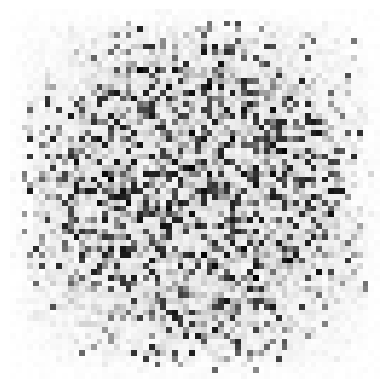

Enter a description for the floor plan you want to generate (or type 'exit' to quit):  exit


Exiting the generator.


In [9]:
# Function to generate an image from a given text description             
def generate_image_from_text(generator, text_description, z_dim=100):
    # Generate random noise
    z = tf.random.normal([1, z_dim])

    # Get text embedding
    text_embedding = get_text_embedding([text_description])  # Pass text as a list

    # Generate image from noise and text embedding
    generated_image = generator(tf.concat([z, text_embedding], axis=1), training=False)

    # Rescale image from [-1, 1] to [0, 1] for display
    generated_image = (generated_image + 1) / 2.0

    return generated_image[0, :, :, 0]  # Return the grayscale image

# Continuous prompt for user input to generate multiple images
while True:
    text_description = input("Enter a description for the floor plan you want to generate (or type 'exit' to quit): ")

    if text_description.lower() == 'exit':
        print("Exiting the generator.")
        break

    # Generate and display the image based on the user prompt
    generated_image = generate_image_from_text(generator, text_description)

    plt.imshow(generated_image, cmap='gray')
    plt.axis('off')
    plt.show()


In [10]:
# At the end of your training function or after training completes:
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')

print("Models saved successfully.")

Models saved successfully.


In [14]:
# Save the generator weights
generator.save_weights('/kaggle/working/generator_model.weights.h5')

# Save the discriminator weights
discriminator.save_weights('/kaggle/working/discriminator_model.weights.h5')


In [18]:
import pickle

# Save the generator model
generator_json = generator.to_json()  # Get the model architecture as JSON
with open('/kaggle/working/generator_model.json', 'w') as json_file:
    json_file.write(generator_json)

# Save the generator weights
generator.save_weights('/kaggle/working/generator_weights.h5')

# Save the architecture as pickle
with open('/kaggle/working/generator_model.pkl', 'wb') as file:
    pickle.dump(generator_json, file)

# Save the discriminator model
discriminator_json = discriminator.to_json()  # Get the model architecture as JSON
with open('/kaggle/working/discriminator_model.json', 'w') as json_file:
    json_file.write(discriminator_json)

# Save the discriminator weights
discriminator.save_weights('/kaggle/working/discriminator_weights.h5')

# Save the architecture as pickle
with open('/kaggle/working/discriminator_model.pkl', 'wb') as file:
    pickle.dump(discriminator_json, file)

print("Models saved as .json and .pkl successfully.")


ValueError: The filename must end in `.weights.h5`. Received: filepath=/kaggle/working/generator_weights.h5

In [16]:
# Save the entire generator model as .h5
generator.save('/kaggle/working/generator_model.h5')

# Save the entire discriminator model as .h5
discriminator.save('/kaggle/working/discriminator_model.h5')

print("Models saved successfully as .h5 files.")


Models saved successfully as .h5 files.


In [17]:
# Load the generator model
from tensorflow.keras.models import load_model

generator = load_model('/kaggle/working/generator_model.h5')

# Load the discriminator model
discriminator = load_model('/kaggle/working/discriminator_model.h5')

print("Models loaded successfully.")


Models loaded successfully.


In [19]:
import pickle

# Save the generator model architecture (as JSON) and weights separately
generator_json = generator.to_json()  # Convert the model architecture to JSON

# Save the architecture as a pickle file
with open('/kaggle/working/generator_model.pkl', 'wb') as file:
    pickle.dump(generator_json, file)

# Save the generator weights
generator.save_weights('/kaggle/working/generator_model_weights.h5')

# Save the discriminator model architecture (as JSON) and weights separately
discriminator_json = discriminator.to_json()  # Convert the model architecture to JSON

# Save the architecture as a pickle file
with open('/kaggle/working/discriminator_model.pkl', 'wb') as file:
    pickle.dump(discriminator_json, file)

# Save the discriminator weights
discriminator.save_weights('/kaggle/working/discriminator_model_weights.h5')

print("Models saved as .pkl and weights saved as .h5.")


ValueError: The filename must end in `.weights.h5`. Received: filepath=/kaggle/working/generator_model_weights.h5

In [20]:
# Save the generator weights (make sure the full extension is ".weights.h5")
generator.save_weights('/kaggle/working/generator_model.weights.h5', overwrite=True)

# Save the discriminator weights (make sure the full extension is ".weights.h5")
discriminator.save_weights('/kaggle/working/discriminator_model.weights.h5', overwrite=True)


In [21]:
import os

# Remove the existing file if it's there
if os.path.exists('/kaggle/working/generator_model.weights.h5'):
    os.remove('/kaggle/working/generator_model.weights.h5')

# Save the generator weights
generator.save_weights('/kaggle/working/generator_model.weights.h5', overwrite=True)

# Same for discriminator
if os.path.exists('/kaggle/working/discriminator_model.weights.h5'):
    os.remove('/kaggle/working/discriminator_model.weights.h5')

# Save the discriminator weights
discriminator.save_weights('/kaggle/working/discriminator_model.weights.h5', overwrite=True)


In [22]:
# Save the full model (this includes architecture and weights)
generator.save('/kaggle/working/generator_model.h5')
discriminator.save('/kaggle/working/discriminator_model.h5')


In [23]:
import pickle

# Save the generator model architecture (as JSON) into a .pkl file
generator_json = generator.to_json()

# Save architecture as .pkl
with open('/kaggle/working/generator_model.pkl', 'wb') as file:
    pickle.dump(generator_json, file)

# Save the generator weights as .weights.h5
generator.save_weights('/kaggle/working/generator_model.weights.h5')

# Save the discriminator model architecture (as JSON) into a .pkl file
discriminator_json = discriminator.to_json()

# Save architecture as .pkl
with open('/kaggle/working/discriminator_model.pkl', 'wb') as file:
    pickle.dump(discriminator_json, file)

# Save the discriminator weights as .weights.h5
discriminator.save_weights('/kaggle/working/discriminator_model.weights.h5')

print("Models' architecture saved as .pkl and weights saved as .weights.h5 files.")


Models' architecture saved as .pkl and weights saved as .weights.h5 files.


In [24]:
from tensorflow.keras.models import model_from_json
import pickle

# Load the generator architecture from the .pkl file
with open('/kaggle/working/generator_model.pkl', 'rb') as file:
    generator_json = pickle.load(file)

# Recreate the model architecture
generator = model_from_json(generator_json)

# Load the generator weights
generator.load_weights('/kaggle/working/generator_model.weights.h5')

# Load the discriminator architecture from the .pkl file
with open('/kaggle/working/discriminator_model.pkl', 'rb') as file:
    discriminator_json = pickle.load(file)

# Recreate the model architecture
discriminator = model_from_json(discriminator_json)

# Load the discriminator weights
discriminator.load_weights('/kaggle/working/discriminator_model.weights.h5')

print("Models' architecture and weights loaded successfully.")


Models' architecture and weights loaded successfully.


In [27]:
# Save the discriminator model architecture in JSON format
discriminator_json = discriminator.to_json()
with open('/kaggle/working/discriminator_model.json', 'w') as json_file:
    json_file.write(discriminator_json)

print("Discriminator model architecture saved in JSON format.")


Discriminator model architecture saved in JSON format.
